In [1]:
%matplotlib inline
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy.stats as st
import seaborn as sns
import plotly.graph_objects as go
from typing import Dict, Any, Optional
import plotly.express as px
import ast

_FIG_SIZE=(6,5)

_BENCHMARK_COMPARISONS = dict(
    method=[
        "Static",
        "Static",
        "SET",
        "SET",
        "DeepR",
        "DeepR",
        "SNFS (ERK)",
        "SNFS (ERK)",
        "DSR",
        "DSR",
        "Top-KAST",
        "Top-KAST",
        "MEST (x0.67+EM)",  # Matches flops of RigL
        "MEST (x0.67+EM)",  # Matches flops of RigL
        "DSB-16",
        "DSB-16",
        "SR-STE",
        "SR-STE",
        ],
    sparsity=[
        80,
        90,
        80,
        90,
        80,
        90,
        80,
        90,
        80,
        90,
        80,  # backward sparsity
        90,  # backward sparsity
        80,
        90,
        50,
        75,
        75,
        93.75,
        ],
    mean=[
        72.1,
        67.7,
        72.9,
        69.6,
        71.7,  # From DSR paper
        70.2,  # From DSR Paper
        75.2,  # From Rigl paper
        73.0,   # From Rigl paper
        73.3,  # From DSR paper
        71.6,   # from dsr paper
        74.76, # Top-kast -> 90% sparse backwards
        70.42,  # Top-kast -> 90% sparse backwards
        75.39,
        72.58,
        76.33,
        74.04,
        76.2,
        71.5,
        ],
    std=[
        0.04,
        0.12,
        0.39,
        0.23,
        0,
        0,
        0.11,
        0.04,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0
        ], 
    dense_backwards=[
        False,  #static
        False,
        False,  # set
        False,
        False,   # deepr
        False,
        True,  # snfs
        True,
        False,  # DSR but kinda yes as sparse backwards > forwards
        False,   # but kinda yes as sparse backwards > forwards
        False,  # top kast
        False,
        False,  # mest
        False,
        False,  # dsb
        False,
        True,  # sr-ste
        True
        ],
    dense_forwards=[
        False,  # static
        False,
        False,  # set
        False,
        False,  # deepr
        False,
        True,  # snfs
        True,
        False,  # DSR
        False,
        False,  # top kast
        False,
        False,  # mest
        False,
        False,  # dsb
        False,
        True,  # sr-ste
        True
    ],
    unstructured=[
        True,  # static
        True,
        True,  # set 
        True,
        True,  # deepr
        True,
        True,  # snfs
        True,
        True,  # dsr
        True,
        True,  # topkast 
        True,
        True,  # MEST did try block sparsity but only for cifar-100
        True,   # MEST did try block sparsity but only for cifar-100
        False,  # dsb
        False,
        False,  # sr-ste
        False  
    ],    
)

# _BENCHMARK_COMPARISONS ={
#     "imagenet": dict(
#         static=dict(s80=(72.1, 0.04), s90=(67.7,0.12)),
#         SET=dict(s80=(72.9, 0.39), s90=(69.6, 0.23)),
#         SNFS=dict(s80=(75.2, 0.11), s90=(73.0, 0.04)),
#         GMP=dict(s80=(75.6, 0), s90=(73.9,0)),
#         LTR=dict(s80=(75.6,0), s90=(-100, -100)),
#         RigL_ITOP=dict(s80=(75.84, 0.05), s90=(73.82,0.08)),
#         RigL_ITOPx2=dict(s80=(76.91, 0.07), s90=(75.50,0.09)),
#     )
# }
_MIN_SAL_PER_LAYER=[1, 2, 3, 1, 1, 7, 3, 1, 7, 3, 1, 4, 2, 1, 2, 7, 2, 1, 7, 2, 1, 7, 2, 1, 4, 2, 1, 2, 7, 2, 1, 7, 2, 1, 7, 2, 1, 7, 2, 1, 7, 2, 1, 4, 2, 1, 2, 7, 2, 1, 7, 2, 1]
_VIT_MIN_SAL=0.95

_RESNET18_BENCHMARK=0.9545
_WIDE_RESNET_BENCHMARK=0.95
_IMAGENET_BENCHMARK=0.7674
_VIT_BENCHMARK=0.7835
_BEST_MIN_SAL_THRES=0.3
_MEAN_MARKER=dict(marker="x", alpha=0.9)
_SAMPLE_MARKER=dict(s=7.5, marker='.', alpha=0.2)
_PLOT_FUNCT="plot"

_GROUPBY_VARS = [
    "rigl.const_fan_in",
    "rigl.dense_allocation",
    "rigl.dynamic_ablation",
    "rigl.min_salient_weights_per_neuron",
]
_SUMMARY_COLS = [
    "name",
    "sweep_id",
    "tags",
    "best_accuracy",
    "rigl.const_fan_in",
    "rigl.dense_allocation",
    "rigl.min_salient_weights_per_neuron",
    "epoch"
]
_SRIGL_PARAMS = {
    'dense_allocation': {
        0: 0.01,
        1: 0.05,
        2: 0.0625,
        3: 0.1,
        4: 0.2,
        5: 0.25,
       },
    'parameters': {0: 274072,
    1: 1289784,
    2: 1611784,
    3: 2571656,
    4: 5113920,
    5: 6391944,}
    ,
    'dense_params': {0: 25557032,
    1: 25557032,
    2: 25557032,
    3: 25557032,
    4: 25557032,
    5: 25557032,
    },
'flops': {0: 210148061.279257,
  1: 1006217258.8635536,
  2: 1254965374.5630252,
  3: 1988961489.7515674,
  4: 3395291627.141983,
  5: 3903734360.67288},
}

_SR_STE_PARAMS = {
    'dense_allocation': {
        0: 0.0625,
        1: 0.25,
    },
    'parameters': {
        0: 3.52*1e6,
        1: 7.93*1e6
    },
    'dense_params': {
        0: 25557032,
        1: 25557032,
    },
    "mean": {
        0: 71.5,
        1: 76.2,
    },
    "upper_bound": {
        0: 71.5,
        1: 76.2,
    },
    "lower_bound": {
        0: 71.5,
        1: 76.2,
    },
    "macs": {
        0: 0.44e9,
        1: 1.17e9
    },
    "flops": {
        0: 0.44e9*2,
        1: 1.17e9*2, 
    }
}

_SRIGL_PARAMS = pd.DataFrame(_SRIGL_PARAMS)
_SR_STE_PARAMS = pd.DataFrame(_SR_STE_PARAMS)
plt.style.use("../plt_plot_style.mplstyle")

# flops_df = pd.read_csv("../flops.csv")


In [2]:
imagenet_benchmarks  = pd.DataFrame(_BENCHMARK_COMPARISONS)
imagenet_benchmarks["upper_bound"] = imagenet_benchmarks["mean"]+imagenet_benchmarks["std"]
imagenet_benchmarks["lower_bound"] = imagenet_benchmarks["mean"]-imagenet_benchmarks["std"]
imagenet_benchmarks


,method,sparsity,mean,std,dense_backwards,dense_forwards,unstructured,upper_bound,lower_bound
0,Static,80.00,72.10,0.04,False,False,True,72.14,72.06
1,Static,90.00,67.70,0.12,False,False,True,67.82,67.58
2,SET,80.00,72.90,0.39,False,False,True,73.29,72.51
3,SET,90.00,69.60,0.23,False,False,True,69.83,69.37
4,DeepR,80.00,71.70,0.00,False,False,True,71.70,71.70
5,DeepR,90.00,70.20,0.00,False,False,True,70.20,70.20
6,SNFS (ERK),80.00,75.20,0.11,True,True,True,75.31,75.09
7,SNFS (ERK),90.00,73.00,0.04,True,True,True,73.04,72.96
8,DSR,80.00,73.30,0.00,False,False,True,73.30,73.30
9,DSR,90.00,71.60,0.00,False,False,True,71.60,71.60


In [3]:
_SRIGL_PARAMS = pd.read_csv("../flops_and_params.csv")
_SRIGL_PARAMS["dense_allocation"] = _SRIGL_PARAMS["rigl.dense_allocation"]
_SRIGL_PARAMS


,Unnamed: 0,rigl.dense_allocation,flops,model,params,normalized_flops,training_flops,normalized_training_flops,dense_allocation
0,0,NaN,8.189482e+09,resnet50,25530472.0,1.000000,2.456845e+10,1.000000,NaN
1,1,0.0100,2.101481e+08,resnet50,1079578.0,0.025661,6.304442e+08,0.025661,0.0100
2,2,0.0500,1.006217e+09,resnet50,2099700.0,0.122867,3.018652e+09,0.122867,0.0500
3,3,0.0625,1.254965e+09,resnet50,2418458.0,0.153241,3.764896e+09,0.153241,0.0625
4,4,0.1000,1.988961e+09,resnet50,3374716.0,0.242868,5.966884e+09,0.242868,0.1000
5,5,0.2000,3.395292e+09,resnet50,5920909.0,0.414592,1.018587e+10,0.414592,0.2000
6,6,0.2500,3.903734e+09,resnet50,7181400.0,0.476677,1.171120e+10,0.476677,0.2500


In [4]:
structured_sparse_benchmarks= pd.DataFrame(
    dict(
        method=["SR-STE", "SR-STE",],
        sparsity=[75, 93.75],
        mean=[76.2,71.5],
        upper_bound=[76.2,71.5],
        lower_bound=[76.2,71.5],
    )
)
structured_sparse_benchmarks


,method,sparsity,mean,upper_bound,lower_bound
0,SR-STE,75.00,76.2,76.2,76.2
1,SR-STE,93.75,71.5,71.5,71.5


In [5]:
def fill_na_cols(df):
    df["rigl.min_salient_weights_per_neuron"] = df["rigl.min_salient_weights_per_neuron"].fillna(0)
    df["rigl.dynamic_ablation"] = df["rigl.dynamic_ablation"].fillna(False)
    df.loc[df["model.name"].isna(), "model.name"] = df["model"]
    df.loc[df["model"].isna(), "model"] = df["model.name"]
    return df
df = pd.read_csv("../processed_results.csv", index_col="id")
df = fill_na_cols(df)
df.head()


/tmp/ipykernel_3072429/2571894223.py:7: DtypeWarning: Columns (1,2,4,5,8,9,11,12,30,31,32,36,37,38,40,43,44,45,46,48,50,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,28

,Annotated Predictions 0._type,Annotated Predictions 0.format,Annotated Predictions 0.height,Annotated Predictions 0.path,Annotated Predictions 0.sha256,Annotated Predictions 0.size,Annotated Predictions 0.width,Annotated Predictions 1._type,Annotated Predictions 1.format,Annotated Predictions 1.height,...,z-self_attention-Max-Grad-Per-Filter.values,z-self_attention-Max-Inactive_Grad,z-self_attention-Max-Inactive_Weight,z-self_attention-Max-Weight-Per-Filter._type,z-self_attention-Max-Weight-Per-Filter.bins,z-self_attention-Max-Weight-Per-Filter.values,z-self_attention-Weight-Dist._type,z-self_attention-Weight-Dist.bins,z-self_attention-Weight-Dist.values,z-self_attention_total-active-neurons
id,,,,,,,,,,,,,,,,,,,,,
1ag1nd4s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[10, 0, 23, 205, 303, 261, 200, 136, 113, 84, ...",0.0,0.0,histogram,"[0, 0.004848943557590246, 0.009697887115180492...","[10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",histogram,"[-0.31033238768577576, -0.30119460821151733, -...","[3, 1, 2, 5, 3, 3, 4, 8, 24, 32, 38, 72, 116, ...",2294.0
tdhnmg61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[1, 9, 32, 136, 248, 293, 214, 172, 110, 52, 4...",0.0,0.0,histogram,"[1.5548888843142095e-09, 0.009707697335130088,...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 11, 13, 52, ...",histogram,"[-0.6212925314903259, -0.6025781631469727, -0....","[1, 1, 2, 4, 0, 3, 5, 10, 11, 11, 22, 19, 21, ...",2304.0
wv84lt70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[1, 293, 615, 295, 145, 79, 102, 124, 113, 109...",0.0,0.0,histogram,"[2.4851254387669992e-09, 0.00804928934824619, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 10, 11, 22, ...",histogram,"[-0.5151543617248535, -0.5004738569259644, -0....","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 4, 8, 6, ...",2304.0
3fitd8e7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30u6fnmd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def model_state_filter(df, epoch=250):
    return df.loc[(df["state"]=="finished") & (df["epoch"]==epoch)]

def display_group_by(df, groupby_vars, sort_by = "accuracy"):
    return df.groupby(groupby_vars).mean().sort_values(by=sort_by, ascending=False)[sort_by]

def get_model_name_filter(df, model_name):
    return df.loc[((df['model.name']==model_name) | (df['model']==model_name))] 

def get_sparse_grad_flow(df):
    return df.loc[df["rigl.init_method_str"] == "grad_flow_init"]

def get_sparse_saliency(df):
    return df[~df["name"].str.contains("salients_only")]
    # return df.loc[df["rigl.use_sparse_const_fan_in_for_ablation"]==True]
    

def get_model_results(df, model_name="resnet18", expected_epochs=250):
    if expected_epochs is not None:
        df = model_state_filter(df, expected_epochs)
    df = get_model_name_filter(df, model_name)
    df = get_sparse_grad_flow(df)
    # model_df = get_sparse_saliency(model_df)
    return df


# resnet18=get_model_results(df, "resnet18", 250)
# wide_resnet22=get_model_results(df, "wide_resnet22", 250)

cifar_const_fan = df.loc[df['tags'].str.contains("sweep_1fik36lx")]
resnet18_const_fan = cifar_const_fan.loc[(cifar_const_fan["model"]=="resnet18") &  (cifar_const_fan["rigl.min_salient_weights_per_neuron"] == _BEST_MIN_SAL_THRES)]
resnet18_og_rigl = df.loc[(df['sweep_id']=="a2uywunn") & (df["model"]=="resnet18")]
resnet18_no_ablation = df.loc[(df["sweep_id"]=="fn7pgfly") & (df["rigl.min_salient_weights_per_neuron"]==0)& (df["model"]=="resnet18")]  # TODO: Replace with new sweep
resnet18 = pd.concat([resnet18_const_fan, resnet18_og_rigl, resnet18_no_ablation])
resnet_ids=resnet18.index

wide_resnet22_const_fan = cifar_const_fan.loc[(cifar_const_fan["model"]=="wide_resnet22") &  (cifar_const_fan["rigl.min_salient_weights_per_neuron"] == _BEST_MIN_SAL_THRES)]
wide_resnet22_og_rigl = df.loc[(df['sweep_id']=="a2uywunn") & (df["model"]=="wide_resnet22")]
wide_resnet22_no_ablation = df.loc[(df["sweep_id"]=="fn7pgfly") & (df["rigl.min_salient_weights_per_neuron"]==0)& (df["model"]=="wide_resnet22")]  # TODO: Replace with new sweep
wide_resnet22 = pd.concat([wide_resnet22_og_rigl, wide_resnet22_const_fan, wide_resnet22_no_ablation])
wide_res_ids=wide_resnet22.index

imagenet=get_model_results(df, "resnet50", 103)
imagenet_og_rigl = imagenet.loc[imagenet["rigl.const_fan_in"]==False]
imagenet_x5=get_model_results(df, "resnet50", 512)  # TODO: Update with new
imagenet_x2=get_model_results(df, "resnet50", 205)
imagenet_x2=imagenet_x2.loc[imagenet_x2["tags"].str.contains("narval_cluster")]
imagnet_net_const_fan_no_ablation_sweep_id = "snb0sphc"
imagenet_no_ablation = imagenet.loc[imagenet["sweep_id"] == imagnet_net_const_fan_no_ablation_sweep_id] 
imagnet_net_const_fan_x1_with_ablation_tag = "x1-steps"
imagenet_st_sre_comparison_tag = "sr-ste-benchmarks"
imagenet_x1 = df.loc[df["tags"].str.contains(imagnet_net_const_fan_x1_with_ablation_tag)]
imagenet_st_sre_comparison = df.loc[df["tags"].str.contains(imagenet_st_sre_comparison_tag)]
imagenet = pd.concat([imagenet_no_ablation, imagenet_x1, imagenet_x5, imagenet_og_rigl, imagenet_x2, imagenet_st_sre_comparison])

skinny_resnet = df.loc[df['sweep_id'] == "jporfu3v"]
resnet18_99_50 = cifar_const_fan.loc[(cifar_const_fan["model"]=="resnet18") &  (cifar_const_fan["rigl.min_salient_weights_per_neuron"] == 0.5) * (cifar_const_fan["rigl.dense_allocation"]==0.01)]
resnet18_og_rigl_001 = resnet18_og_rigl.loc[resnet18_og_rigl["rigl.dense_allocation"] == 0.01]
skinny_resnet = pd.concat([skinny_resnet, resnet18_99_50, resnet18_og_rigl_001, ])



# imagenet = imagenet.loc[imagenet["sweep_id"].isin(["aw7o7hz7", "snb0sphc"])]


In [7]:
vit_results = get_model_results(df, "vit", 151)
vit_results = vit_results.loc[(vit_results["rigl.dynamic_ablation"]==True) & (vit_results["rigl.const_fan_in"]==True) & (vit_results["tags"].str.contains("vit_fixed_t_end"))]
display(vit_results.groupby(["epoch", "rigl.const_fan_in", "rigl.dynamic_ablation", "rigl.dense_allocation", "rigl.min_salient_weights_per_neuron"]).count()["tags"])
# vit_results.loc[(vit_results["rigl.const_fan_in"]==True) & (vit_results["rigl.sparsity_distribution"]=="uniform")].groupby("rigl.min_salient_weights_per_neuron").mean()["best_accuracy"].sort_values()


epoch  rigl.const_fan_in  rigl.dynamic_ablation  rigl.dense_allocation  rigl.min_salient_weights_per_neuron
151.0  True               True                   0.1                    0.30                                   1
                                                                        0.50                                   1
                                                                        0.75                                   1
                                                                        0.90                                   1
                                                                        0.95                                   1
                                                                        0.99                                   1
                                                 0.2                    0.30                                   1
                                                                        0.50                         

In [8]:
vit_results[["epoch", "rigl.const_fan_in", "rigl.dynamic_ablation", "rigl.dense_allocation", "training.seed","rigl.min_salient_weights_per_neuron","tags"]]


,epoch,rigl.const_fan_in,rigl.dynamic_ablation,rigl.dense_allocation,training.seed,rigl.min_salient_weights_per_neuron,tags
id,,,,,,,
aikh5crb,151.0,True,True,0.2,42,0.75,['vit_fixed_t_end']
3q0koovk,151.0,True,True,0.2,42,0.95,['vit_fixed_t_end']
s6d10uh3,151.0,True,True,0.2,42,0.90,['vit_fixed_t_end']
2vin5wtl,151.0,True,True,0.2,42,0.99,['vit_fixed_t_end']
0p0wrlb0,151.0,True,True,0.2,42,0.95,"['vit-benchmarks', 'vit_fixed_t_end']"
dqitpg28,151.0,True,True,0.2,42,0.75,['vit_fixed_t_end']
lpgwlb89,151.0,True,True,0.2,42,0.50,['vit_fixed_t_end']
fidhize5,151.0,True,True,0.2,42,0.30,['vit_fixed_t_end']
dwlyqdgj,151.0,True,True,0.1,42,0.99,['vit_fixed_t_end']


In [9]:
vit_results = get_model_results(df, "vit", 151)
vit_results = vit_results.loc[vit_results["tags"].str.contains("vit_fixed_t_end")]
vit_srigl_with_ablation = vit_results.loc[
    (vit_results["tags"].str.contains("vit_fixed_t_end")) & \
    (vit_results["rigl.const_fan_in"]==True) & \
    (vit_results["rigl.min_salient_weights_per_neuron"]==_VIT_MIN_SAL) & \
    (vit_results["rigl.sparsity_distribution"]=="uniform") & \
    (vit_results["training.seed"]==42) & \
    (~vit_results.index.isin(["0p0wrlb0","1kdtc78r"]))]
vit_rigl = vit_results.loc[(vit_results["rigl.const_fan_in"]==False) & (vit_results["rigl.sparsity_distribution"]=="uniform") & (vit_results["tags"].str.contains("vit_fixed_t_end"))]
# vit_results = pd.concat([vit_srigl_with_ablation, vit_srigl_no_ablation, vit_rigl])
vit_results = pd.concat([vit_srigl_with_ablation, vit_rigl])

vit_results.groupby(["epoch", "rigl.const_fan_in", "rigl.dynamic_ablation", "rigl.dense_allocation"], dropna=False).count()['tags']


epoch  rigl.const_fan_in  rigl.dynamic_ablation  rigl.dense_allocation
151.0  False              True                   0.1                      1
                                                 0.2                      1
       True               False                  0.1                      1
                                                 0.2                      1
                          True                   0.1                      1
                                                 0.2                      1
Name: tags, dtype: int64

In [10]:
vit_results[["rigl.dense_allocation", "best_accuracy", "rigl.const_fan_in", "rigl.dynamic_ablation"]].sort_values(by="best_accuracy")


,rigl.dense_allocation,best_accuracy,rigl.const_fan_in,rigl.dynamic_ablation
id,,,,
1ng3llec,0.1,0.71264,True,False
2vns1fqj,0.2,0.73496,True,False
nrblbn15,0.1,0.76004,True,True
3p6dparl,0.1,0.76390,False,True
3q0koovk,0.2,0.77472,True,True
1ige8ylm,0.2,0.77878,False,True


In [11]:
mobilenet_small = get_model_results(df, "mobilenet_small", None)
mobilenet_small.groupby(["epoch", "rigl.const_fan_in", "rigl.dynamic_ablation", "rigl.dense_allocation"], dropna=False).count()['tags']


epoch  rigl.const_fan_in  rigl.dynamic_ablation  rigl.dense_allocation
600.0  False              True                   0.01                     1
                                                 0.05                     1
                                                 0.10                     1
                                                 0.20                     1
       True               True                   0.01                     1
                                                 0.05                     1
                                                 0.10                     1
                                                 0.20                     1
                                                 NaN                      1
Name: tags, dtype: int64

In [12]:
mobilenet_large = get_model_results(df, "mobilenet_large", None)
mobilenet_large.groupby(["epoch", "rigl.const_fan_in", "rigl.dynamic_ablation", "rigl.dense_allocation"], dropna=False).count()['tags']


epoch  rigl.const_fan_in  rigl.dynamic_ablation  rigl.dense_allocation
600.0  False              True                   0.01                     1
                                                 0.05                     1
                                                 0.10                     1
                                                 0.20                     1
       True               True                   0.01                     1
                                                 0.05                     1
                                                 0.10                     1
                                                 0.20                     1
                                                 NaN                      1
Name: tags, dtype: int64

In [13]:
resnet18_og_rigl.loc[resnet18_og_rigl["rigl.dense_allocation"] == 0.01]


,Annotated Predictions 0._type,Annotated Predictions 0.format,Annotated Predictions 0.height,Annotated Predictions 0.path,Annotated Predictions 0.sha256,Annotated Predictions 0.size,Annotated Predictions 0.width,Annotated Predictions 1._type,Annotated Predictions 1.format,Annotated Predictions 1.height,...,z-self_attention-Max-Grad-Per-Filter.values,z-self_attention-Max-Inactive_Grad,z-self_attention-Max-Inactive_Weight,z-self_attention-Max-Weight-Per-Filter._type,z-self_attention-Max-Weight-Per-Filter.bins,z-self_attention-Max-Weight-Per-Filter.values,z-self_attention-Weight-Dist._type,z-self_attention-Weight-Dist.bins,z-self_attention-Weight-Dist.values,z-self_attention_total-active-neurons
id,,,,,,,,,,,,,,,,,,,,,
gp8uog4a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
q1c5ldrm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8euvnykc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47keahsb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jn8w8nmg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
skinny_resnet.loc[(skinny_resnet["rigl.const_fan_in"] == False) & (~skinny_resnet["rigl.dense_allocation"].isna())][_SUMMARY_COLS].sort_values(by="best_accuracy", ascending=False)


,name,sweep_id,tags,best_accuracy,rigl.const_fan_in,rigl.dense_allocation,rigl.min_salient_weights_per_neuron,epoch
id,,,,,,,,
y29qhvrw,skinny_resnet18_cifar10_dense_alloc-0.01_const...,jporfu3v,[],0.9308,False,0.01,0.5,250.0
q1c5ldrm,resnet18_cifar10_dense_alloc-0.01_const_fan_in...,a2uywunn,[],0.9303,False,0.01,0.0,250.0
shxuffw0,skinny_resnet18_cifar10_dense_alloc-0.01_const...,jporfu3v,[],0.9302,False,0.01,0.5,250.0
nfhyyil0,skinny_resnet18_cifar10_dense_alloc-0.01_const...,jporfu3v,[],0.9300,False,0.01,0.5,250.0
mi3b4qs7,skinny_resnet18_cifar10_dense_alloc-0.01_const...,jporfu3v,[],0.9298,False,0.01,0.5,250.0
gp8uog4a,resnet18_cifar10_dense_alloc-0.01_const_fan_in...,a2uywunn,[],0.9298,False,0.01,0.0,250.0
jq9npp65,skinny_resnet18_cifar10_dense_alloc-0.01_const...,jporfu3v,[],0.9295,False,0.01,0.5,250.0
jn8w8nmg,resnet18_cifar10_dense_alloc-0.01_const_fan_in...,a2uywunn,[],0.9288,False,0.01,0.0,250.0
47keahsb,resnet18_cifar10_dense_alloc-0.01_const_fan_in...,a2uywunn,[],0.9287,False,0.01,0.0,250.0


In [15]:
gdf = resnet18.groupby(_GROUPBY_VARS).count()["best_accuracy"]
print(f"Any run set with more than 5 seeds? {(gdf != 5).any()}.")
resnet_ids=resnet18.index
df.loc[resnet_ids].groupby(["rigl.dense_allocation"])['best_accuracy'].count()  # We expect 15, 5 seeds x 3 experiments (OG, no ablation, ablation)


Any run set with more than 5 seeds? False.


rigl.dense_allocation
0.01    15
0.05    15
0.10    15
0.20    15
0.30    15
0.40    15
0.50    15
Name: best_accuracy, dtype: int64

In [16]:
gdf = wide_resnet22.groupby(_GROUPBY_VARS).count()["best_accuracy"]
print(f"Any run set with more than 5 seeds? {(gdf != 5).any()}.")
wide_res_ids=wide_resnet22.index
df.loc[wide_res_ids].groupby(["rigl.dense_allocation"])['best_accuracy'].count()  # We expect 45, 5 seeds and 3 experiments (OG, no ablation, ablation)


Any run set with more than 5 seeds? False.


rigl.dense_allocation
0.01    15
0.05    15
0.10    15
0.20    15
0.30    15
0.40    15
0.50    15
Name: best_accuracy, dtype: int64

In [17]:
import copy
this_group = copy.deepcopy(_GROUPBY_VARS)
this_group.extend(["epoch"])
gdf = imagenet.groupby(this_group).count()["best_accuracy"]
gdf  # TODO: Remove 0.005 runs once other x5 runs finish


rigl.const_fan_in  rigl.dense_allocation  rigl.dynamic_ablation  rigl.min_salient_weights_per_neuron  epoch
False              0.0100                 True                   0.005                                103.0    1
                   0.0500                 True                   0.005                                103.0    1
                   0.1000                 True                   0.005                                103.0    1
                   0.2000                 True                   0.005                                103.0    1
True               0.0100                 False                  0.000                                103.0    1
                                          True                   0.005                                512.0    1
                                                                 0.300                                103.0    1
                                                                                                     

In [18]:
# Vit ablation experiments
vit_results = get_model_results(df, "vit", 151)
vit_min_sal_ablation = vit_results.loc[vit_results["tags"].str.contains("vit_min_sal_sparse_mha_sweep")]
vit_min_sal_ablation.groupby(["epoch", "rigl.const_fan_in", "rigl.dynamic_ablation", "rigl.dense_allocation"]).count()['tags']


epoch  rigl.const_fan_in  rigl.dynamic_ablation  rigl.dense_allocation
151.0  True               True                   0.25                     12
                                                 0.30                     12
                                                 0.50                     12
Name: tags, dtype: int64

In [19]:
vit_mha_conv_ablation = vit_results.loc[vit_results["tags"].str.contains("vit-mha-sweep")]
vit_mha_conv_ablation.groupby(["epoch", "rigl.const_fan_in", "rigl.dynamic_ablation", "rigl.dense_allocation"]).count()['tags']

epoch  rigl.const_fan_in  rigl.dynamic_ablation  rigl.dense_allocation
151.0  True               True                   0.3                      4
Name: tags, dtype: int64

In [20]:
vit_mha_conv_ablation

,Annotated Predictions 0._type,Annotated Predictions 0.format,Annotated Predictions 0.height,Annotated Predictions 0.path,Annotated Predictions 0.sha256,Annotated Predictions 0.size,Annotated Predictions 0.width,Annotated Predictions 1._type,Annotated Predictions 1.format,Annotated Predictions 1.height,...,z-self_attention-Max-Grad-Per-Filter.values,z-self_attention-Max-Inactive_Grad,z-self_attention-Max-Inactive_Weight,z-self_attention-Max-Weight-Per-Filter._type,z-self_attention-Max-Weight-Per-Filter.bins,z-self_attention-Max-Weight-Per-Filter.values,z-self_attention-Weight-Dist._type,z-self_attention-Weight-Dist.bins,z-self_attention-Weight-Dist.values,z-self_attention_total-active-neurons
id,,,,,,,,,,,,,,,,,,,,,
1pvth6zw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[84, 315, 297, 200, 134, 92, 49, 41, 58, 44, 4...",0.000000e+00,0.0,histogram,"[0.11457457393407822, 0.12405742576811463, 0.1...","[7, 44, 87, 147, 233, 238, 199, 195, 163, 140,...",histogram,"[-0.6286388635635376, -0.6075432896614075, -0....","[2, 0, 2, 2, 1, 3, 8, 7, 13, 10, 20, 28, 26, 3...",2304.0
13lvl991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[1571, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.405072e-17,0.0,histogram,"[0, 0.004411676898598671, 0.008823353797197342...","[1571, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",histogram,"[-0.28234732151031494, -0.2735743224620819, -0...","[2, 0, 2, 0, 4, 12, 22, 31, 40, 44, 67, 103, 1...",733.0
1267v95w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[1563, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.039921e-17,0.0,histogram,"[0, 0.004881370346993208, 0.009762740693986416...","[1563, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",histogram,"[-0.3124077022075653, -0.3027524948120117, -0....","[1, 1, 0, 0, 1, 2, 4, 1, 11, 13, 18, 39, 49, 9...",741.0
oqkeyb9v,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[888, 398, 217, 202, 237, 134, 73, 38, 19, 20,...",0.000000e+00,0.0,histogram,"[0.10136542469263077, 0.10828407888766378, 0.1...","[1, 7, 21, 54, 88, 151, 146, 201, 175, 175, 13...",histogram,"[-0.5441592931747437, -0.5274010300636292, -0....","[1, 1, 2, 3, 5, 4, 6, 15, 18, 16, 23, 26, 60, ...",2304.0


## PLOTTING

In [21]:
# PLOTTING HELPERS
# _COLORS=['#00a5bb','#f79141','#d81e52',  '#6c77c5', '#499585', '#6cb2c5' , '#c5ba6c', '#56ce93', '#d88fBf', '#ffd505', "#000000"]

_COLORS = sns.color_palette("tab10").as_hex()
from typing import Tuple
def get_confidence_bounds_df(df: pd.DataFrame, alpha=0.95, target_col:str = "best_accuracy", x_col="sparsity"):
    df = df.copy()
    results = {
        x_col:[],
        "mean":[],
        "lower_bound":[],
        "upper_bound":[],
    }
    for sparsity in df[x_col].unique():
        this_df = df.loc[df[x_col] == sparsity]
        results[x_col].append(sparsity)
        results["mean"].append(this_df[target_col].mean())
        lower, upper = st.t.interval(
            alpha=alpha,
            df=len(this_df[target_col])-1,
            loc=this_df[target_col].mean(),
            scale=st.sem(this_df[target_col])
        )
        results["lower_bound"].append(lower)
        results["upper_bound"].append(upper)
    return pd.DataFrame(results)

from typing import List
def series_name_plot_mapper(const_fan_in: bool, dynamic_ablation: bool, epoch_values: List[int], epoch: int) -> Tuple[str]:
    epoch_values = sorted(epoch_values)
    epoch_color_value_inc = {epoch: 2+i for i, epoch in enumerate(epoch_values)}
    if const_fan_in and dynamic_ablation:
        name = "SRigL"
        if len (epoch_values) >1:
            steps_multiplier = round(epoch / epoch_values[0])
            # if steps_multiplier == 1:
            #     color=_COLORS[2]
            # else:
            #     color=_COLORS[epoch_color_value_inc[epoch]]
            if steps_multiplier != 1:
                name = name + f" x{steps_multiplier}"
        return name, _COLORS[epoch_color_value_inc[epoch]]
    elif const_fan_in and not dynamic_ablation:
        return "SRigL w/o ablation", _COLORS[1]
    elif not const_fan_in:
        return "RigL", _COLORS[0]
    else: 
        raise ValueError(f"No name / colour map found!")
    

In [22]:
plt.style.use("./plt_plot_style.mplstyle")

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: "DejaVu Sans"
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: "DejaVu Sans"


35
35
35
35
35
35
4
4
6
4
3


/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


4
4


/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


11
4
85


/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',


4
5


/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',


4
5


/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',


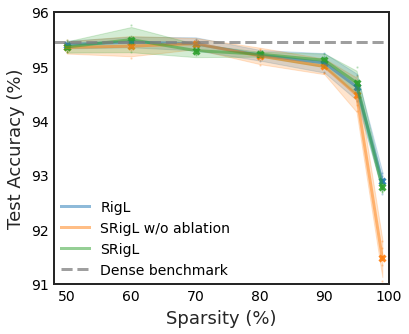

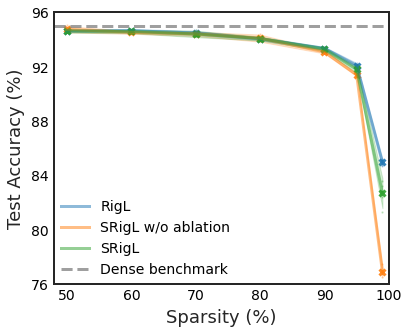

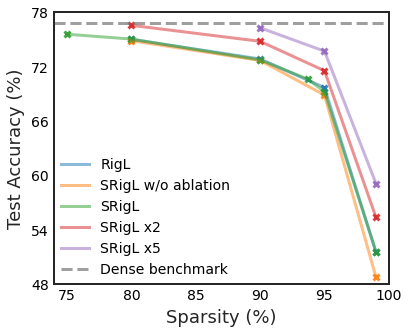

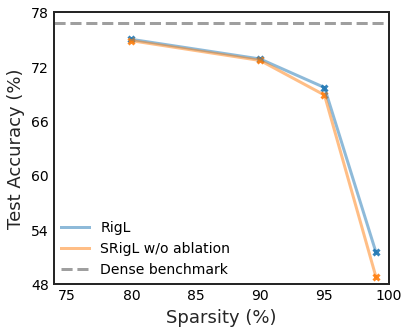

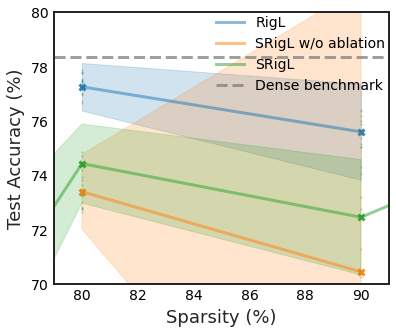

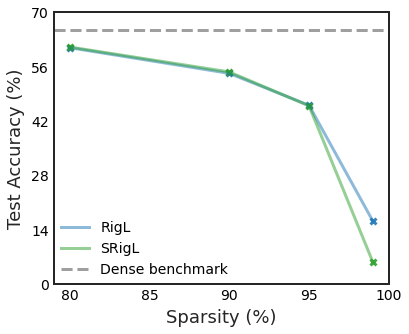

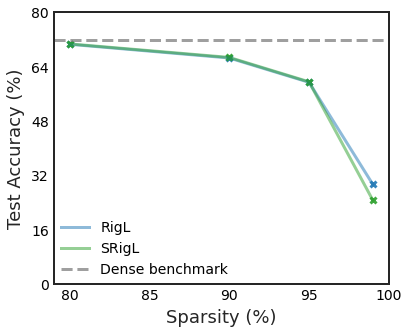

In [23]:

def get_accuracy_vs_sparsity_plot(model_name, ids, dense_benchmark_value, plot_99_sparsity=True, ylim=[0.9,1.0], xlim=[0.49,1.0], plot_error_bars: bool = True, x_ticks = None, sparse_benchmarks=None, log_y=False, legend_kwargs = {}):
    # _BENCHMARK_VALUE = 0.9506

    plot_df = df.loc[ids].copy().sort_values(by="rigl.dense_allocation")
    plot_df["rigl.dynamic_ablation"].fillna(False, inplace=True)
    plot_df = plot_df.loc[plot_df["state"] == "finished"]
    if not plot_99_sparsity:
        plot_df = plot_df.loc[plot_df["rigl.dense_allocation"] != 0.01]
    plot_df["sparsity"] = (1-plot_df["rigl.dense_allocation"])*100
    plot_df["best_accuracy"] = plot_df["best_accuracy"]*100
    plot_dfs = []
    fig, ax = plt.subplots(figsize=_FIG_SIZE)
    
    benchmark_colour_idx = 0
    if sparse_benchmarks is not None:
        # these_colors = sns.color_palette("Set2")
        
        
        for idx, method in enumerate(sparse_benchmarks["method"].unique()):
            color = sns.color_palette("tab10").as_hex()[benchmark_colour_idx]
            benchmark_colour_idx+=1
            df_slice = sparse_benchmarks.loc[(sparse_benchmarks["method"] == method)]
            # color=these_colors[idx]
            if _PLOT_FUNCT=='scatter':
                ax.scatter(
                    df_slice["sparsity"], df_slice["mean"], label=method, color=color, **_MEAN_MARKER
                )
            else:
                ax.plot(
                    df_slice["sparsity"], df_slice["mean"],  marker='x', color=color, alpha=0.9, label=method
                )   
                if plot_error_bars:
                    ax.fill_between(
                        df_slice["sparsity"],
                        df_slice["upper_bound"],
                        df_slice["lower_bound"],
                        color=color,
                        alpha=0.20
                    )


    for idx, (epoch, fan_in, dynamic_ablation) in enumerate(plot_df.groupby(["epoch", "rigl.const_fan_in", "rigl.dynamic_ablation"], dropna=False).count().index.unique()):
        # print(epoch, fan_in, dynamic_ablation)
        # if fan_in != True:
        #     continue  
        # if epoch not in [250.0, 103.0, 151.0]:
        #     print(epoch)
        #     continue
        df_slice = plot_df.loc[(plot_df["rigl.const_fan_in"] == fan_in) & (plot_df["rigl.dynamic_ablation"] == dynamic_ablation) & (plot_df["epoch"] == epoch)]
        print(len(df_slice))            
        name, color = series_name_plot_mapper(fan_in, dynamic_ablation, plot_df["epoch"].unique(), int(epoch))
        agg_results = get_confidence_bounds_df(df_slice, target_col="best_accuracy")
        # display(agg_results)
        if _PLOT_FUNCT =="scatter":
            ax.scatter(
                agg_results["sparsity"], agg_results["mean"], label=name, color=color, **_MEAN_MARKER
            )
            yerr= [a["upper_bound"]-a["mean"] for _,a in agg_results.iterrows()]
            ax.errorbar(agg_results["sparsity"], agg_results["mean"], yerr=yerr,fmt="none", color=color, elinewidth=0.5, capsize=3)
            # ax.scatter(
            #     df_slice["sparsity"], df_slice["best_accuracy"], marker='.', label=None, color=color, alpha=0.2,
            # )
            
        else:
            ax.plot(
                agg_results["sparsity"], agg_results["mean"], label=name, color=color, marker=None, alpha=0.50
            )
            ax.scatter(
                agg_results["sparsity"], agg_results["mean"], label=None, color=color, **_MEAN_MARKER,
            )
            ax.scatter(
                df_slice["sparsity"], df_slice["best_accuracy"], color=color, **_SAMPLE_MARKER
            )
            if plot_error_bars:
                ax.fill_between(
                    agg_results["sparsity"],
                    agg_results["upper_bound"],
                    agg_results["lower_bound"],
                    color=color,
                    alpha=0.20
                )


    ax.plot(xlim, [dense_benchmark_value*100, dense_benchmark_value*100], "--",  label="Dense benchmark", color=_COLORS[-3], alpha=0.75)
    model_name_dict = dict(
        resnet18="ResNet18",
        wide_resnet22="WideResNet22"
    )
    plt.xlabel('Sparsity (%)')
    plt.ylabel('Test Accuracy (%)')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, **legend_kwargs)
    ax.set_xlim(xlim)
    if not log_y:
        ax.set_ylim(ylim)
        tick_spaces=5
        y_tick_eps = (max(ylim) - min(ylim))/tick_spaces
        y_ticks = [min(ylim)+y_tick_eps*x for x in range(tick_spaces+1)]
        ax.set_yticks(y_ticks)
    if x_ticks is not None:
        ax.set_xticks(x_ticks)
    if log_y:
        ax.set_yscale("log")
    fig.savefig(f"../fig/{model_name}.png", dpi=600, bbox_inches="tight")
    fig.savefig(f"../fig/{model_name}.svg",format="svg", bbox_inches="tight")
    fig.savefig(f"../fig/{model_name}.pdf",format="pdf", bbox_inches="tight")
    return fig

resnet18_params=dict(
    ids = resnet_ids,
    model_name ="../fig/resnet18",
    dense_benchmark_value = _RESNET18_BENCHMARK,
    plot_99_sparsity=True,
    ylim=[91,96],
    xlim=[48,100],
    # log_y=True
)

wide_resnet22_params=dict(
    ids = wide_res_ids,
    model_name ="../fig/wide_resnet22",
    dense_benchmark_value = _WIDE_RESNET_BENCHMARK,
    plot_99_sparsity=True,
    ylim=[76,96],
    xlim=[48,100]
)

imagenet_params=dict(
    ids = imagenet.index.to_list(),
    model_name ="../fig/resnet50",
    dense_benchmark_value = _IMAGENET_BENCHMARK,
    plot_99_sparsity=True,
    ylim=[48,78],
    xlim=[74,100],
    plot_error_bars=True,
    sparse_benchmarks = None
    # x_ticks=[80,90,95,99],
)

imagenet_presentation=dict(
    ids = imagenet.loc[(imagenet["epoch"]==103) & ( (imagenet["rigl.dynamic_ablation"]==False) | (imagenet["rigl.const_fan_in"]==False))][_SUMMARY_COLS].index.to_list(),
    model_name ="../fig/resnet50-presentation",
    dense_benchmark_value = _IMAGENET_BENCHMARK,
    plot_99_sparsity=True,
    ylim=[48,78],
    xlim=[74,100],
    plot_error_bars=True,
    sparse_benchmarks = None
    # x_ticks=[80,90,95,99],
)

imagenet.loc[(imagenet["epoch"]==103) & ( (imagenet["rigl.dynamic_ablation"]==False) | (imagenet["rigl.const_fan_in"]==False))][_SUMMARY_COLS]

vit_params=dict(
    ids = vit_results.index.to_list(),
    model_name ="../fig/vit",
    dense_benchmark_value = _VIT_BENCHMARK,
    plot_99_sparsity=True,
    ylim=[70,80],
    xlim=[79,91],
    plot_error_bars=True,
    sparse_benchmarks = None,
    # x_ticks=[80,90,95,99],
    legend_kwargs={"loc": "upper right", "fontsize": 14,"borderpad": 0.0, "borderaxespad": 0.25}

)

mobilenet_small_params = dict(
    ids = mobilenet_small.index.to_list(),
    model_name ="../fig/mobilenet_small",
    dense_benchmark_value = mobilenet_small.loc[mobilenet_small["rigl.dense_allocation"].isna()]['best_accuracy'].item(),
    plot_99_sparsity=True,
    ylim=[0,70],
    xlim=[79,100],
    plot_error_bars=True,
    sparse_benchmarks = None,
    # x_ticks=[80,90,95,99],
    # legend_kwargs={"loc": "upper right", "fontsize": 14,"borderpad": 0.0, "borderaxespad": 0.25}
    
)

mobilenet_large_params = dict(
    ids = mobilenet_large.index.to_list(),
    model_name ="../fig/mobilenet_large",
    dense_benchmark_value = mobilenet_large.loc[mobilenet_large["rigl.dense_allocation"].isna()]['best_accuracy'].item(),
    plot_99_sparsity=True,
    ylim=[0,80],
    xlim=[79,100],
    plot_error_bars=True,
    sparse_benchmarks = None,
    # x_ticks=[80,90,95,99],
    # legend_kwargs={"loc": "upper right", "fontsize": 14,"borderpad": 0.0, "borderaxespad": 0.25}
    
)

# _MEAN_MARKER=dict(s=80, facecolors='none', marker='x', alpha=1.0, linewidths=2)
# _MEAN_MARKER=dict(marker="x", alpha=0.9)
# _SAMPLE_MARKER=dict(s=7.5, marker='.', alpha=0.2)
_MEAN_MARKER=dict(marker="x", alpha=0.9)
_SAMPLE_MARKER=dict(s=7.5, marker='.', alpha=0.2)
_PLOT_FUNCT="plot"
fig = get_accuracy_vs_sparsity_plot(**resnet18_params)
fig = get_accuracy_vs_sparsity_plot(**wide_resnet22_params)
fig = get_accuracy_vs_sparsity_plot(**imagenet_params)
fig = get_accuracy_vs_sparsity_plot(**imagenet_presentation)
fig = get_accuracy_vs_sparsity_plot(**vit_params)
fig = get_accuracy_vs_sparsity_plot(**mobilenet_small_params)
fig = get_accuracy_vs_sparsity_plot(**mobilenet_large_params)


4
5


/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',


4
5


/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',


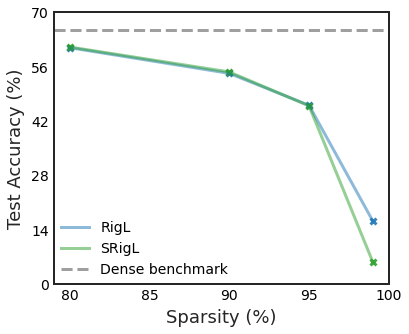

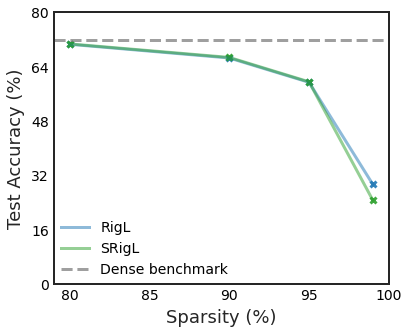

In [24]:
# ViT sweep 

def get_accuracy_vs_sparsity_plot(model_name, ids, dense_benchmark_value, plot_99_sparsity=True, ylim=[0.9,1.0], xlim=[0.49,1.0], plot_error_bars: bool = True, x_ticks = None, sparse_benchmarks=None, log_y=False, legend_kwargs = {}):
    # _BENCHMARK_VALUE = 0.9506

    plot_df = df.loc[ids].copy().sort_values(by="rigl.dense_allocation")
    plot_df["rigl.dynamic_ablation"].fillna(False, inplace=True)
    plot_df = plot_df.loc[plot_df["state"] == "finished"]
    if not plot_99_sparsity:
        plot_df = plot_df.loc[plot_df["rigl.dense_allocation"] != 0.01]
    plot_df["sparsity"] = (1-plot_df["rigl.dense_allocation"])*100
    plot_df["best_accuracy"] = plot_df["best_accuracy"]*100
    plot_dfs = []
    fig, ax = plt.subplots(figsize=_FIG_SIZE)
    
    benchmark_colour_idx = 0
    if sparse_benchmarks is not None:
        # these_colors = sns.color_palette("Set2")
        
        
        for idx, method in enumerate(sparse_benchmarks["method"].unique()):
            color = sns.color_palette("tab10").as_hex()[benchmark_colour_idx]
            benchmark_colour_idx+=1
            df_slice = sparse_benchmarks.loc[(sparse_benchmarks["method"] == method)]
            # color=these_colors[idx]
            if _PLOT_FUNCT=='scatter':
                ax.scatter(
                    df_slice["sparsity"], df_slice["mean"], label=method, color=color, **_MEAN_MARKER
                )
            else:
                ax.plot(
                    df_slice["sparsity"], df_slice["mean"],  marker='x', color=color, alpha=0.9, label=method
                )   
                if plot_error_bars:
                    ax.fill_between(
                        df_slice["sparsity"],
                        df_slice["upper_bound"],
                        df_slice["lower_bound"],
                        color=color,
                        alpha=0.20
                    )


    for idx, (epoch, fan_in, dynamic_ablation) in enumerate(plot_df.groupby(["epoch", "rigl.const_fan_in", "rigl.dynamic_ablation"], dropna=False).count().index.unique()):
        # print(epoch, fan_in, dynamic_ablation)
        # if fan_in != True:
        #     continue  
        # if epoch not in [250.0, 103.0, 151.0]:
        #     print(epoch)
        #     continue
        df_slice = plot_df.loc[(plot_df["rigl.const_fan_in"] == fan_in) & (plot_df["rigl.dynamic_ablation"] == dynamic_ablation) & (plot_df["epoch"] == epoch)]
        print(len(df_slice))            
        name, color = series_name_plot_mapper(fan_in, dynamic_ablation, plot_df["epoch"].unique(), int(epoch))
        agg_results = get_confidence_bounds_df(df_slice, target_col="best_accuracy")
        # display(agg_results)
        if _PLOT_FUNCT =="scatter":
            ax.scatter(
                agg_results["sparsity"], agg_results["mean"], label=name, color=color, **_MEAN_MARKER
            )
            yerr= [a["upper_bound"]-a["mean"] for _,a in agg_results.iterrows()]
            ax.errorbar(agg_results["sparsity"], agg_results["mean"], yerr=yerr,fmt="none", color=color, elinewidth=0.5, capsize=3)
            # ax.scatter(
            #     df_slice["sparsity"], df_slice["best_accuracy"], marker='.', label=None, color=color, alpha=0.2,
            # )
            
        else:
            ax.plot(
                agg_results["sparsity"], agg_results["mean"], label=name, color=color, marker=None, alpha=0.50
            )
            ax.scatter(
                agg_results["sparsity"], agg_results["mean"], label=None, color=color, **_MEAN_MARKER,
            )
            ax.scatter(
                df_slice["sparsity"], df_slice["best_accuracy"], color=color, **_SAMPLE_MARKER
            )
            if plot_error_bars:
                ax.fill_between(
                    agg_results["sparsity"],
                    agg_results["upper_bound"],
                    agg_results["lower_bound"],
                    color=color,
                    alpha=0.20
                )


    ax.plot(xlim, [dense_benchmark_value*100, dense_benchmark_value*100], "--",  label="Dense benchmark", color=_COLORS[-3], alpha=0.75)
    model_name_dict = dict(
        resnet18="ResNet18",
        wide_resnet22="WideResNet22"
    )
    plt.xlabel('Sparsity (%)')
    plt.ylabel('Test Accuracy (%)')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, **legend_kwargs)
    ax.set_xlim(xlim)
    if not log_y:
        ax.set_ylim(ylim)
        tick_spaces=5
        y_tick_eps = (max(ylim) - min(ylim))/tick_spaces
        y_ticks = [min(ylim)+y_tick_eps*x for x in range(tick_spaces+1)]
        ax.set_yticks(y_ticks)
    if x_ticks is not None:
        ax.set_xticks(x_ticks)
    if log_y:
        ax.set_yscale("log")
    fig.savefig(f"../fig/{model_name}.png", dpi=600, bbox_inches="tight")
    fig.savefig(f"../fig/{model_name}.svg",format="svg", bbox_inches="tight")
    fig.savefig(f"../fig/{model_name}.pdf",format="pdf", bbox_inches="tight")
    return fig

vit_params=dict(
    ids = vit_results.index.to_list(),
    model_name ="../fig/vit",
    dense_benchmark_value = _VIT_BENCHMARK,
    plot_99_sparsity=True,
    ylim=[70,80],
    xlim=[79,91],
    plot_error_bars=True,
    sparse_benchmarks = None,
    # x_ticks=[80,90,95,99],
    legend_kwargs={"loc": "upper right", "fontsize": 14,"borderpad": 0.0, "borderaxespad": 0.25}

)


mobilenet_large_params = dict(
    ids = mobilenet_large.index.to_list(),
    model_name ="../fig/mobilenet_large",
    dense_benchmark_value = mobilenet_large.loc[mobilenet_large["rigl.dense_allocation"].isna()]['best_accuracy'].item(),
    plot_99_sparsity=True,
    ylim=[0,80],
    xlim=[79,100],
    plot_error_bars=True,
    sparse_benchmarks = None,
    # x_ticks=[80,90,95,99],
    # legend_kwargs={"loc": "upper right", "fontsize": 14,"borderpad": 0.0, "borderaxespad": 0.25}
    
)

# _MEAN_MARKER=dict(s=80, facecolors='none', marker='x', alpha=1.0, linewidths=2)
# _MEAN_MARKER=dict(marker="x", alpha=0.9)
# _SAMPLE_MARKER=dict(s=7.5, marker='.', alpha=0.2)
_MEAN_MARKER=dict(marker="x", alpha=0.9)
_SAMPLE_MARKER=dict(s=7.5, marker='.', alpha=0.2)
_PLOT_FUNCT="plot"

fig = get_accuracy_vs_sparsity_plot(**mobilenet_small_params)
fig = get_accuracy_vs_sparsity_plot(**mobilenet_large_params)


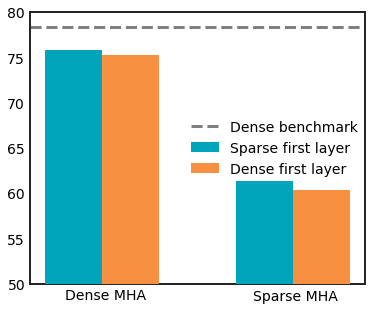

In [25]:
# Let's do a grouped bar plot here

vit_mha_conv_ablation.groupby(["rigl.dense_allocation", "rigl.keep_first_layer_dense", "rigl.ignore_mha_layers"])["tags"].count()

def plot_mha_conv_ablation(ids, plot_error_bars=True, dense_benchmark_value=0):
    plot_df = df.loc[ids].copy().sort_values(by="best_accuracy")
    plot_df["rigl.dynamic_ablation"].fillna(False, inplace=True)
    plot_df = plot_df.loc[plot_df["state"] == "finished"]
    plot_df["sparsity"] = (1-plot_df["rigl.dense_allocation"])*100
    plot_df["best_accuracy"] = plot_df["best_accuracy"]*100
    fig, ax = plt.subplots(figsize=_FIG_SIZE)
    width=0.3

    x = np.arange(2)
    for idx, keep_first_layer_dense in enumerate([False, True]):
        df_slice = plot_df.loc[plot_df["rigl.keep_first_layer_dense"] == keep_first_layer_dense]
        df_slice = df_slice.sort_values(by="rigl.ignore_mha_layers", ascending=False)
        offset = width * idx
        name = "Dense first layer" if keep_first_layer_dense else "Sparse first layer"
        ax.bar(x+offset, df_slice["best_accuracy"], width, label=name, align="center", zorder=3)

    plt.axhline(y=dense_benchmark_value*100, color='black', linestyle='--', label='Dense benchmark', alpha=0.5)
    ax.set_xticks(x+0.33/2, ["Dense MHA", "Sparse MHA"])
    ax.set_ylim([50,80])
    ax.legend()
    return fig

fig = plot_mha_conv_ablation(vit_mha_conv_ablation.index.to_list(), dense_benchmark_value=_VIT_BENCHMARK)
fig.savefig("../figs/vit-mha-ablation.png", dpi=600, bbox_inches="tight")
fig.savefig("../figs/vit-mha-ablation.pdf", dpi=600, bbox_inches="tight")

In [26]:
# Scatter here
vit_min_sal_ablation.groupby(["rigl.dense_allocation", "rigl.min_salient_weights_per_neuron", "rigl.ignore_mha_layers"])["tags"].count()

rigl.dense_allocation  rigl.min_salient_weights_per_neuron  rigl.ignore_mha_layers
0.25                   0.10                                 False                     1
                                                            True                      1
                       0.30                                 False                     1
                                                            True                      1
                       0.50                                 False                     1
                                                            True                      1
                       0.70                                 False                     1
                                                            True                      1
                       0.90                                 False                     1
                                                            True                      1
                       0.95          

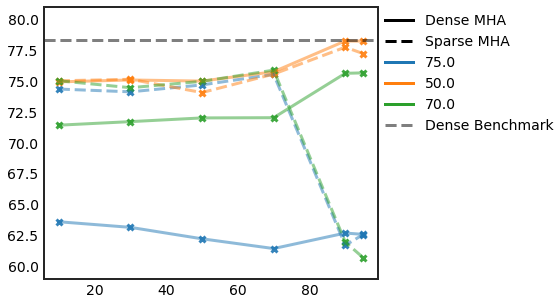

In [35]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def plot_vit_min_sal_sweep(ids, dense_benchmark_value=_VIT_BENCHMARK, xcol="rigl.min_salient_weights_per_neuron"):
    xcol="rigl.min_salient_weights_per_neuron"
    plot_df = df.loc[ids].copy().sort_values(by=xcol)
    plot_df[xcol]=plot_df[xcol]*100
    plot_df["rigl.dynamic_ablation"].fillna(False, inplace=True)
    plot_df = plot_df.loc[plot_df["state"] == "finished"]
    plot_df["sparsity"] = (1-plot_df["rigl.dense_allocation"])*100
    plot_df["best_accuracy"] = plot_df["best_accuracy"]*100

    fig, ax = plt.subplots(figsize=_FIG_SIZE)
    
    label_handles = [
        Line2D([0], [0], linestyle="-", label="Dense MHA", color="black"),
        Line2D([0], [0], linestyle="--", label="Sparse MHA", color="black"),
    ]
    for idx, sparsity in enumerate(plot_df['sparsity'].unique()):
        color = _COLORS[idx]
        label_handles.append(Line2D([0], [0], color=color, label=sparsity))
        for dense_mha in plot_df["rigl.ignore_mha_layers"].unique():
            line_style = "-" if dense_mha else "--"
            df_slice = plot_df.loc[(plot_df["sparsity"]==sparsity) & (plot_df["rigl.ignore_mha_layers"]==dense_mha)]
            ax.scatter(df_slice[xcol], df_slice["best_accuracy"], color=color, **_MEAN_MARKER)
            label = f"{int(sparsity)} - {'Dense' if dense_mha else 'Sparse'} MHA"
            # ax.plot(df_slice[xcol], df_slice["best_accuracy"], color=color, marker=None, alpha=0.5, linestyle=line_style, label=label)
            ax.plot(df_slice[xcol], df_slice["best_accuracy"], color=color, marker=None, alpha=0.5, linestyle=line_style, label=label)

    plt.axhline(y=dense_benchmark_value*100, color='black', linestyle='--', label='Dense benchmark', alpha=0.5)
    label_handles.append(Line2D([0],[0], color='black', alpha=0.5, linestyle="--", label="Dense Benchmark"))
    ax.set_ylim([50,80])
    # ax.legend()
    ax.legend(handles=label_handles, bbox_to_anchor=(1,1))
    ax.set_ylim(59,81)
    return fig


fig = plot_vit_min_sal_sweep(ids=vit_min_sal_ablation.index.to_list())
fig.savefig("../figs/vit-min-sal-mha-sparse.png", dpi=600, bbox_inches="tight")
fig.savefig("../figs/vit-min-sal-mha-sparse.pdf", dpi=600, bbox_inches="tight")

In [ ]:
# sparse mha + 70% min sal seems best?

In [184]:
vit_min_sal_ablation['best_accuracy'].min()

0.6071199774742126

In [172]:
p_df

,Annotated Predictions 0._type,Annotated Predictions 0.format,Annotated Predictions 0.height,Annotated Predictions 0.path,Annotated Predictions 0.sha256,Annotated Predictions 0.size,Annotated Predictions 0.width,Annotated Predictions 1._type,Annotated Predictions 1.format,Annotated Predictions 1.height,...,z-self_attention-Max-Inactive_Grad,z-self_attention-Max-Inactive_Weight,z-self_attention-Max-Weight-Per-Filter._type,z-self_attention-Max-Weight-Per-Filter.bins,z-self_attention-Max-Weight-Per-Filter.values,z-self_attention-Weight-Dist._type,z-self_attention-Weight-Dist.bins,z-self_attention-Weight-Dist.values,z-self_attention_total-active-neurons,sparsity
id,,,,,,,,,,,,,,,,,,,,,


/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2162: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2163: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2162: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/mike/condensed-s

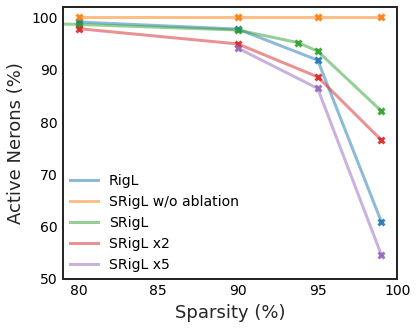

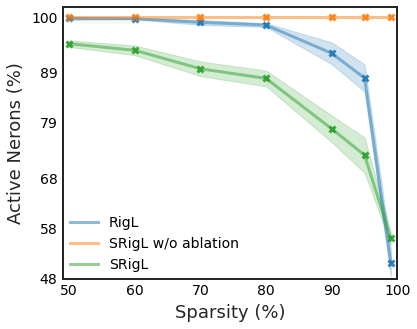

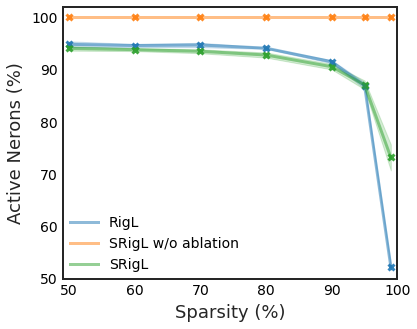

In [30]:
def plot_active_neurons_vs_sparsity(df, model_name="", ylim=[90,100], xlim=[49,100]):
    _TARGET_COL="_TOTAL_PERCENTAGE_ACTIVE_NEURONS"
    df=df.copy(deep=True)
    df = df.sort_values(by="rigl.dense_allocation")
    df["sparsity"] = (1-df["rigl.dense_allocation"])*100
    plot_dfs = []
    fig, ax = plt.subplots(figsize=_FIG_SIZE)

    for idx, (epoch, fan_in, dynamic_ablation) in enumerate(df.groupby(["epoch", "rigl.const_fan_in", "rigl.dynamic_ablation"], dropna=False).count().index.unique()): 
        df_slice = df.loc[(df["rigl.const_fan_in"] == fan_in) & (df["rigl.dynamic_ablation"] == dynamic_ablation) & (df["epoch"] == epoch)]    
        name, color = series_name_plot_mapper(fan_in, dynamic_ablation, df["epoch"].unique(), int(epoch))
        agg_results = get_confidence_bounds_df(df_slice, target_col=_TARGET_COL)
        # display(agg_results)
        if _PLOT_FUNCT=="scatter":
            ax.scatter(
                agg_results["sparsity"], agg_results["mean"], label=name, color=color, **_MEAN_MARKER
            )
            yerr= [a["upper_bound"]-a["mean"] for _,a in agg_results.iterrows()]
            ax.errorbar(agg_results["sparsity"], agg_results["mean"], yerr=yerr,fmt="none", color=color, elinewidth=0.5, capsize=3)
        else:
            ax.plot(
                agg_results["sparsity"], agg_results["mean"], label=name, color=color, marker=None, alpha=0.50
            )
            ax.scatter(
                agg_results["sparsity"], agg_results["mean"], label=None, color=color, **_MEAN_MARKER,
            )
            
            # ax.plot(
            #     agg_results["sparsity"], agg_results["mean"], label=name, color=color, **_MEAN_MARKER
            # )
            ax.fill_between(
                agg_results["sparsity"],
                agg_results["upper_bound"],
                agg_results["lower_bound"],
                color=color,
                alpha=0.20
            )
            # ax.scatter(
            #     df_slice["sparsity"], df_slice[_TARGET_COL], marker='o', color=color, alpha=0.5
            # )

    plt.xlabel('Sparsity (%)')
    plt.ylabel('Active Nerons (%)')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels,  loc="best")
    leg = ax.legend()
    leg.get_frame().set_linewidth(0.0)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    tick_spaces=5
    y_tick_eps = (max(ylim)-2 - min(ylim))/tick_spaces
    y_ticks = [int(min(ylim)+y_tick_eps*x) for x in range(tick_spaces+1)]
    ax.set_yticks(y_ticks)
    # ax.legend(bbox_to_anchor=.35,0.35)
    fig.savefig(f"../fig/{model_name}_perc_active.png", dpi=600, bbox_inches="tight")
    fig.savefig(f"../fig/{model_name}_perc_active.svg",format="svg", bbox_inches="tight")
    fig.savefig(f"../fig/{model_name}_perc_active.pdf",format="pdf", bbox_inches="tight")
    return fig

# sweep_id_ablation_exp = "a2uywunn"
# df.loc[df["sweep_id"]==sweep_id_ablation_exp]["rigl.dense_allocation"].unique()

# resnet18_const_fan_false_ids=df.loc[(df["sweep_id"]==sweep_id_ablation_exp) & (df["model"]=="resnet18")].index.to_list()
# wide_resnet22_const_fan_false_ids=df.loc[(df["sweep_id"]==sweep_id_ablation_exp) & (df["model"]=="wide_resnet22")].index.to_list()
# imagenet_ids = imagenet.loc[imagenet["rigl.dynamic_ablation"] == True].index
# fig = plot_active_neurons_vs_sparsity(imagenet.loc[imagenet_ids], "imagenet", ylim=[58, 100], xlim=[0.79, 1.0])
# fig = plot_active_neurons_vs_sparsity(df.loc[new_high_sparse_ids+resnet18_const_fan_false_ids], "resnet18", ylim=[50, 100])
# fig = plot_active_neurons_vs_sparsity(df.loc[wide_const_fan_ids+wide_resnet22_const_fan_false_ids], "wide_resnet22", ylim=[50, 100])

fig = plot_active_neurons_vs_sparsity(imagenet, "imagenet", ylim=[50, 102], xlim=[79, 100])
fig = plot_active_neurons_vs_sparsity(df.loc[resnet_ids], "resnet18", ylim=[48, 102])
fig = plot_active_neurons_vs_sparsity(df.loc[wide_res_ids], "wide_resnet22", ylim=[50, 102])


# Min Salient

/tmp/ipykernel_2198263/1754114733.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_sal_df["epoch"] = min_sal_df.loc[min_sal_df["epoch"]==249, 'epoch'] = 250
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: "DejaVu Sans"


(40, 5965)
(5, 5965)
   rigl.min_salient_weights_per_neuron       mean  lower_bound  upper_bound
0                                  0.5  92.413998    92.058808    92.769187
1                                  1.0  92.531997    92.293900    92.770094
2                                  5.0  92.363998    92.195205    92.532790
3                                 10.0  92.631997    92.471443    92.792551
4                                 20.0  92.503998    92.396250    92.611747
5                                 30.0  92.785999    92.670317    92.901680
6                                 40.0  92.667998    92.558546    92.777450
7                                 50.0  92.791996    92.724901    92.859091
(40, 5965)
(5, 5965)
   rigl.min_salient_weights_per_neuron       mean  lower_bound  upper_bound
0                                  0.5  95.087997    94.806574    95.369419
1                                  1.0  95.091999    94.949505    95.234492
2                                  5.0  94.959

/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


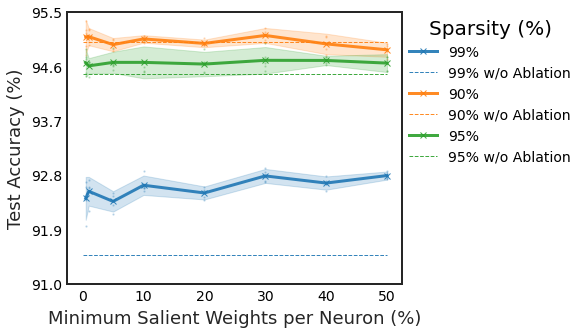

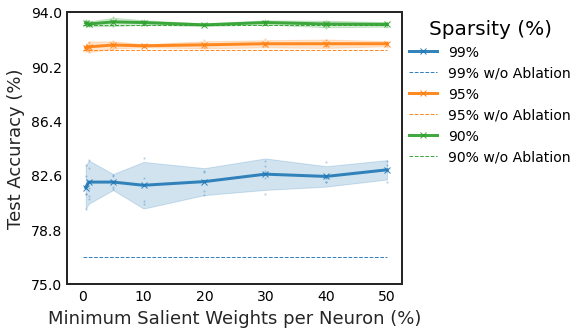

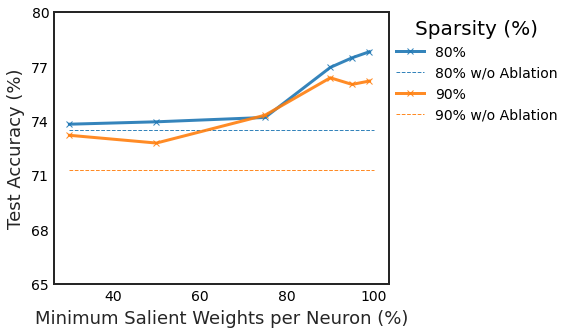

In [31]:
## Hyperparam search for min salient

def plot_min_salient_sweep(df, model_name="", ylim=[90,100], xlim=[49,100], plot_80=False):
    _TARGET_COL="best_accuracy"
    x_col = "rigl.min_salient_weights_per_neuron"
    df=df.copy(deep=True)
    df[_TARGET_COL] = df[_TARGET_COL]*100
    df[x_col] = df[x_col]*100
    df = df.sort_values(by=x_col)
    df["sparsity"] = (1-df["rigl.dense_allocation"])*100
    fig, ax = plt.subplots(figsize=_FIG_SIZE)
    epoch_values = sorted(df["epoch"].unique())
    # epoch_color_value_inc = {epoch: 2+i for i, epoch in enumerate(epoch_values)}
    color_inc = 0
    
    for sparsity in df["sparsity"].unique():
        if not plot_80 and not sparsity > 80:
            continue
        color = _COLORS[color_inc]
        color_inc+=1
        df_slice_ablation = df.loc[(df["sparsity"] == sparsity) & (df["rigl.dynamic_ablation"]==True)]
        df_slice_no_ablation = df.loc[(df["sparsity"] == sparsity) & (df["rigl.dynamic_ablation"]==False)]
        print(df_slice_ablation.shape)
        print(df_slice_no_ablation.shape)
        
        # Dynamic
        name = f"{sparsity:.0f}%"
        if len (epoch_values) >1:
            steps_multiplier = round(epoch / epoch_values[0])
            name = name + f" x{steps_multiplier}"
        agg_results = get_confidence_bounds_df(df_slice_ablation, target_col=_TARGET_COL, x_col=x_col)
        print(agg_results)
        if _PLOT_FUNCT == "scatter":
            ax.scatter(agg_results[x_col], agg_results["mean"], label=name, color=color, **_MEAN_MARKER)
            yerr= [a["upper_bound"]-a["mean"] for _,a in agg_results.iterrows()]
            ax.errorbar(agg_results[x_col], agg_results["mean"], yerr=yerr,fmt="none", color=color, elinewidth=0.5, capsize=3)
        else:
            ax.plot(
                agg_results[x_col], agg_results["mean"], label=name, color=color, **_MEAN_MARKER
            )
            ax.fill_between(
                agg_results[x_col],
                agg_results["upper_bound"],
                agg_results["lower_bound"],
                color=color,
                alpha=0.20
            )
            ax.scatter(
                df_slice_ablation[x_col], df_slice_ablation[_TARGET_COL], color=color, **_SAMPLE_MARKER
            )
        benchmark_val = df_slice_no_ablation[_TARGET_COL].mean()
        ax.plot(xlim, [benchmark_val, benchmark_val], "--",  label=f"{sparsity:.0f}% w/o Ablation", color=color, alpha=0.9, linewidth=1)

    plt.xlabel('Minimum Salient Weights per Neuron (%)')
    plt.ylabel('Test Accuracy (%)')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc="best", bbox_to_anchor=(1,1),framealpha=0)
    # ax.legend(bbox_to_anchor='upper right')
    # leg = ax.legend().get_frame()
    # leg.set_linewidth(0.0)
    
    
    ax.get_legend().set_title("Sparsity (%)")
    ax.set_ylim(ylim)
    # ax.set_xlim(xlim)
    # ax.set_xscale("log")
    tick_spaces=5
    y_tick_eps = (max(ylim) - min(ylim))/tick_spaces
    y_ticks = [min(ylim)+y_tick_eps*x for x in range(tick_spaces+1)]
    ax.set_yticks(y_ticks)
    fig.savefig(f"../fig/{model_name}_salient_sweep.png", dpi=600, bbox_inches="tight")
    fig.savefig(f"../fig/{model_name}_salient_sweep.svg",format="svg", bbox_inches="tight")
    fig.savefig(f"../fig/{model_name}_salient_sweep.pdf",format="pdf", bbox_inches="tight")
    return fig


min_sal_df = df.loc[df["tags"].str.contains("sweep_1fik36lx")]
min_sal_df["epoch"] = min_sal_df.loc[min_sal_df["epoch"]==249, 'epoch'] = 250
min_sal_df = pd.concat([min_sal_df, resnet18_no_ablation, wide_resnet22_no_ablation])
fig = plot_min_salient_sweep(min_sal_df.loc[min_sal_df["model"]=="resnet18"], model_name="resnet18", ylim=[91,95.5], xlim=[0,50])
fig.show()
fig = plot_min_salient_sweep(min_sal_df.loc[min_sal_df["model"]=="wide_resnet22"], model_name="wide_resnet22",ylim=[75,94], xlim=[0,50])
fig.show()

vit_min_sal = df.loc[
        (df["model"]=="vit") & \
        (df["rigl.const_fan_in"]==True) & \
        (df["rigl.sparsity_distribution"]=="uniform") & \
        (df["training.seed"]==42) & \
        (df["epoch"]==151.0) & \
        # (df["rigl.dynamic_ablation"]==True) & \
        (df["tags"].str.contains("_fixed_t_end")) & \
        (~df.index.isin(["0p0wrlb0","1kdtc78r","dqitpg28"]))]

fig = plot_min_salient_sweep(vit_min_sal, model_name="vit",ylim=[65,80], xlim=[30,100], plot_80=True)
fig.show()


In [32]:


# # vit_results = get_model_results(df, "vit", 151)
# vit_results = vit_results.loc[vit_results["tags"].str.contains("vit_fixed_t_end")]
# vit_srigl_with_ablation = vit_results.loc[
#     (vit_results["tags"].str.contains("vit_fixed_t_end")) & \
#     (vit_results["rigl.const_fan_in"]==True) & \
#     (vit_results["rigl.min_salient_weights_per_neuron"]==_VIT_MIN_SAL) & \
#     (vit_results["rigl.sparsity_distribution"]=="uniform") & \
#     (vit_results["training.seed"]==42) & \
#     (~vit_results.index.isin(["0p0wrlb0","1kdtc78r"]))]
# vit_rigl = vit_results.loc[(vit_results["rigl.const_fan_in"]==False) & (vit_results["rigl.sparsity_distribution"]=="uniform") & (vit_results["tags"].str.contains("vit_fixed_t_end"))]
# # vit_results = pd.concat([vit_srigl_with_ablation, vit_srigl_no_ablation, vit_rigl])
# vit_results = pd.concat([vit_srigl_with_ablation, vit_rigl])

# vit_results.groupby(["epoch", "rigl.const_fan_in", "rigl.dynamic_ablation", "rigl.dense_allocation"]).count()


vit_min_sal.groupby(by=["rigl.const_fan_in", "rigl.dynamic_ablation", "tags", "rigl.min_salient_weights_per_neuron", "training.seed"]).count()


Annotated Predictions 0._type  \
rigl.const_fan_in rigl.dynamic_ablation tags                                  rigl.min_salient_weights_per_neuron training.seed                                  
True              False                 ['vit_fixed_t_end']                   0.95                                42                                         0   
                  True                  ['vit-benchmarks', 'vit_fixed_t_end'] 0.95                                42                                         0   
                                        ['vit_fixed_t_end']                   0.30                                42                                         0   
                                                                              0.50                                42                                         0   
                                                                              0.75                                42                                         0   
                                                                              0.90                                42                                         0   
                                                                              0.95                                42                                         0   
                                                                              0.99                                42                                         0   

                                                                                                                                 Annotated Predictions 0.format  \
rigl.const_fan_in rigl.dynamic_ablation tags                                  rigl.min_salient_weights_per_neuron training.seed                                   
True              False                 ['vit_fixed_t_end']                   0.95                                42                                          0   
                  True                  ['vit-benchmarks', 'vit_fixed_t_end'] 0.95                                42                                          0   
                                        ['vit_fixed_t_end']                   0.30                                42                                          0   
                                                                              0.50                                42                                          0   
                                                                              0.75                                42                                          0   
                                                                              0.90                                42                                          0   
                                                                              0.95                                42                                          0   
                                                                              0.99                                42                                          0   

                                                                                                                                 Annotated Predictions 0.height  \
rigl.const_fan_in rigl.dynamic_ablation tags                                  rigl.min_salient_weights_per_neuron training.seed                                   
True              False                 ['vit_fixed_t_end']                   0.95                                42                                          0   
                  True                  ['vit-benchmarks', 'vit_fixed_t_end'] 0.95                                42                                          0   
                                        ['vit_fixed_t_end']                   0.30                                42                                          0   
                                                              

In [33]:
'''
\begin{table}[tp]
\renewcommand{\arraystretch}{0.6}
\begin{center}
\caption{Test accuracy of ResNet-18 trained on CIFAR-10. Mean and 95\% confidence intervals are reported over five runs}\label{table:resnet18_cifar10_table}
\begin{tabular}{@{}cccc@{}}
\toprule
& \gls{origl} & \multicolumn{2}{c}{\gls{srigl}} \\
\cmidrule(lr){3-4}
sparsity (\%) &  & w/o & w/ ablation \\
\midrule
50 & $95.40\pm 0.06$ & $95.35\pm 0.09$ & $95.36\pm 0.08$ \\\addlinespace
60 & $95.45\pm 0.08$ & $95.37\pm 0.15$ & $95.49\pm 0.19$ \\\addlinespace
70 & $95.41\pm 0.10$ & $95.42\pm 0.08$ & $95.29\pm 0.10$ \\\addlinespace
80 & $95.20\pm 0.08$ & $95.19\pm 0.12$ & $95.22\pm 0.04$ \\\addlinespace
90 & $95.06\pm 0.14$ & $95.00\pm 0.11$ & $95.11\pm 0.10$ \\\addlinespace
95 & $94.62\pm 0.20$ & $94.48\pm 0.25$ & $94.70\pm 0.18$ \\\addlinespace
99 & $92.88\pm 0.14$ & $91.47\pm 0.28$ & $92.79\pm 0.09$ \\
\midrule
0 & \multicolumn{3}{c}{\emph{ResNet-18~\citep{he_deep_2016}}:\quad $95.45$}\\
\bottomrule
\end{tabular}
\end{center}
\end{table}

'''


'\n\x08egin{table}[tp]\n\renewcommand{\x07rraystretch}{0.6}\n\x08egin{center}\n\\caption{Test accuracy of ResNet-18 trained on CIFAR-10. Mean and 95\\% confidence intervals are reported over five runs}\\label{table:resnet18_cifar10_table}\n\x08egin{tabular}{@{}cccc@{}}\n\toprule\n& \\gls{origl} & \\multicolumn{2}{c}{\\gls{srigl}} \\\n\\cmidrule(lr){3-4}\nsparsity (\\%) &  & w/o & w/ ablation \\\n\\midrule\n50 & $95.40\\pm 0.06$ & $95.35\\pm 0.09$ & $95.36\\pm 0.08$ \\\x07ddlinespace\n60 & $95.45\\pm 0.08$ & $95.37\\pm 0.15$ & $95.49\\pm 0.19$ \\\x07ddlinespace\n70 & $95.41\\pm 0.10$ & $95.42\\pm 0.08$ & $95.29\\pm 0.10$ \\\x07ddlinespace\n80 & $95.20\\pm 0.08$ & $95.19\\pm 0.12$ & $95.22\\pm 0.04$ \\\x07ddlinespace\n90 & $95.06\\pm 0.14$ & $95.00\\pm 0.11$ & $95.11\\pm 0.10$ \\\x07ddlinespace\n95 & $94.62\\pm 0.20$ & $94.48\\pm 0.25$ & $94.70\\pm 0.18$ \\\x07ddlinespace\n99 & $92.88\\pm 0.14$ & $91.47\\pm 0.28$ & $92.79\\pm 0.09$ \\\n\\midrule\n0 & \\multicolumn{3}{c}{\\emph{ResNet-18~

In [34]:
def get_results_table(df, ids, benchmark_value, caption, label, ) -> str:
    df = get_df_for_table(df, ids)
    df=df.copy(deep=True)
    table_str=""
    table_header=(
        "\\begin{table}[tp]\n"
        "\\renewcommand{\\arraystretch}{0.6}\n"
        "\\begin{center}\n"
        f"\\caption{{{caption}}}\\label{{table:{label}}}\n"
        "\\begin{tabular}{@{}cccc@{}}\n"
        "\\toprule\n"
        "& \\gls{origl} & \\multicolumn{2}{c}{\\gls{srigl}} \\\\ \n"
        "sparsity (\\%) &  & w/o & w/ ablation \\\\ \n"
        "\\midrule"
    )
    
    table_str+=table_header
    df = df.groupby(["rigl.dense_allocation", "rigl.const_fan_in", "rigl.dynamic_ablation"], dropna=True).agg(["mean", "std"])
    # display(df)
    df = df.sort_values(by=("sparsity", "mean"), ascending=True)


    for s in df["sparsity"]["mean"].unique():
        df_slice=df.loc[df["sparsity"]['mean']==s]
        row = get_table_row(df_slice, s)
        table_str+="\n"
        table_str+=row
    
    table_footer = (
        "\n\\midrule \n"
        "0 & \\multicolumn{3}{c}{\\emph{ResNet-18~\\citep{he_deep_2016}}:\\quad "
        f"${benchmark_value:.2f}$}}\\\\ \n"
        "\\bottomrule \n"
        "\\end{tabular} \n"
        "\\end{center} \n"
        "\end{table} \n"
    )
    
    table_str+=table_footer
    return table_str

def get_df_for_table(df, ids, fill_best_nan:bool=True,):
    interested_cols=[
        "rigl.const_fan_in",
        "rigl.dynamic_ablation",
        "rigl.dense_allocation",
        "accuracy",
        "best_accuracy",
        "sparsity"
    ]
    df["sparsity"] = 1-df["rigl.dense_allocation"]
    df_slice = df.loc[ids][interested_cols]
    df = df_slice.copy(deep=True)
    if fill_best_nan:
        df["best_accuracy"].loc[df["best_accuracy"].isna()] = df["accuracy"].loc[df["best_accuracy"].isna()]
        # df["rigl.dynamic_ablation"].fillna(False, inplace=True)
    df["+/-"] = df["best_accuracy"] - df["accuracy"]
    return df
def get_bold_text(mean_std_name):
    for idx, (mean, std, name) in enumerate(mean_std_name):
        if np.isnan(std):
            std=0
        others=list(range(len(mean_std_name)))
        others.pop(idx)
        bold_text = True
        for other in others:
            if mean - std < mean_std_name[other][0]+mean_std_name[other][1]:
                bold_text = False
        if bold_text:
            name = f"\\mathbf{{{name}}}"
            mean_std_name[idx][2] = name
    return mean_std_name

def get_table_row(df_slice, s):
    # Index is dense_alloc, const_fan, dynamic_ablation
    srigl_ablation_slice = df_slice.loc[:, True, True]
    srigl_ablation_mean=srigl_ablation_slice["best_accuracy"]["mean"].item()
    srigl_ablation_std=srigl_ablation_slice["best_accuracy"]["std"].item()
    srigl_ablation_text = f"{srigl_ablation_mean*100:.1f}"
    if not np.isnan(srigl_ablation_std):
        srigl_ablation_text += f"\\pm {srigl_ablation_std*100:.1f}"
    else:
        srigl_ablation_std=0
    vanilla_slice = df_slice.loc[:, False, :]
    vanilla_mean=vanilla_slice["best_accuracy"]["mean"].item()
    vanilla_std=vanilla_slice["best_accuracy"]["std"].item()
    vanilla_text = f"{vanilla_mean*100:.1f}"
    if not np.isnan(vanilla_std):
        vanilla_text += f"\\pm {vanilla_std*100:.1f}"
    else:
        vanilla_std=0
    no_ablation_slice = df_slice.loc[:, True, False]
    no_ablation_mean=no_ablation_slice["best_accuracy"]["mean"].item()
    no_ablation_std=no_ablation_slice["best_accuracy"]["std"].item()
    no_ablation_text = f"{no_ablation_mean*100:.1f}"
    if not np.isnan(no_ablation_std):
        no_ablation_text += f"\\pm {no_ablation_std*100:.1f}"
    else:
        no_ablation_text=no_ablation_text

    mean_std_name = [
        [vanilla_mean, vanilla_std, vanilla_text],
        [no_ablation_mean, no_ablation_std, no_ablation_text],
        [srigl_ablation_mean, srigl_ablation_std, srigl_ablation_text],
    ]
    mean_std_name = get_bold_text(mean_std_name)
    vanilla_text=mean_std_name[0][2]
    no_ablation_text=mean_std_name[1][2]
    srigl_ablation_text=mean_std_name[2][2]
    row_text = f"{s*100:.0f} & ${vanilla_text}$ & ${no_ablation_text}$ & ${srigl_ablation_text}$ \\\\ \\addlinespace"
    return row_text



resnet18_table_args = dict(
    df=df,
    ids=resnet_ids,
    benchmark_value=_RESNET18_BENCHMARK,
    caption= "Test accuracy of ResNet-18 trained with RigL on CIFAR-10. Mean and 95\% confidence intervals are reported over five runs",
    label="resnet18_cifar10_table"
    
)

wide_resnet_table_args = dict(
    df=df,
    ids=wide_res_ids,
    benchmark_value=_WIDE_RESNET_BENCHMARK,
    caption= "Test accuracy of Wide ResNet-22 trained on CIFAR-10. Mean and 95\% confidence intervals are reported over five runs",
    label="wide_resnet22_table"
    
)

imagenet_table_ids = pd.concat([imagenet_no_ablation, imagenet_x1, imagenet_og_rigl]).index
imagenet_table_args = dict(
    df=df,
    ids=imagenet_table_ids,
    benchmark_value=_IMAGENET_BENCHMARK,
    caption= "Test accuracy of ResNet-50 trained on ImageNet.",
    label="resnet50_imagenet_table"
    
)

vit_table_args = dict(
    df=df,
    ids=vit_results.index,
    benchmark_value=_VIT_BENCHMARK,
    caption= "Test accuracy of ViT-B/16 trained on ImageNet.",
    label="vit_imagenet_table"
    
)
print(get_results_table(**vit_table_args))
# for kwargs in [resnet18_table_args, wide_resnet_table_args, imagenet_table_args, vit_table_args]:
#     print(get_results_table(**kwargs))


\begin{table}[tp]
\renewcommand{\arraystretch}{0.6}
\begin{center}
\caption{Test accuracy of ViT-B/16 trained on ImageNet.}\label{table:vit_imagenet_table}
\begin{tabular}{@{}cccc@{}}
\toprule
& \gls{origl} & \multicolumn{2}{c}{\gls{srigl}} \\ 
sparsity (\%) &  & w/o & w/ ablation \\ 
\midrule
80 & $\mathbf{77.9}$ & $73.5$ & $77.5$ \\ \addlinespace
90 & $\mathbf{76.4}$ & $71.3$ & $76.0$ \\ \addlinespace
\midrule 
0 & \multicolumn{3}{c}{\emph{ResNet-18~\citep{he_deep_2016}}:\quad $0.78$}\\ 
\bottomrule 
\end{tabular} 
\end{center} 
\end{table} 



/tmp/ipykernel_2198263/2339283529.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["best_accuracy"].loc[df["best_accuracy"].isna()] = df["accuracy"].loc[df["best_accuracy"].isna()]


In [35]:
_VIT_BENCHMARK


0.7835

In [36]:
## Imagenet giga table
def imagenet_benchmark_table(df):
    slice = df.loc[(df["unstructured"]==True) & (df["dense_backwards"]==False)]
    table = ""
    for method in slice["method"].unique():
        table += append_row(table, row=df.loc[df['method']==method])
    table += "\\midrule \n"
    slice = df.loc[(df["unstructured"]==True) & (df["dense_backwards"]==True)]
    for method in slice["method"].unique():
        table += append_row(table, row=df.loc[df['method']==method])
    table += "\\midrule \n"
    slice = df.loc[(df["unstructured"]==False) & (df["dense_backwards"]==False)]
    for method in slice["method"].unique():
        table += append_row(table, row=df.loc[df['method']==method])
    table += "\\midrule \n"
    slice = df.loc[(df["unstructured"]==False) & (df["dense_backwards"]==True)]
    for method in slice["method"].unique():
        table += append_row(table, row=df.loc[df['method']==method])
    return table

def append_row(table, row):
    s_50_text = get_accuracy_text(row, sparsity=50)
    s_75_text = get_accuracy_text(row, sparsity=75)
    s_80_text = get_accuracy_text(row, sparsity=80)
    s_90_text = get_accuracy_text(row, sparsity=90)
    s_93_text = get_accuracy_text(row, sparsity=93.75)
    row = f'{row["method"].unique().item()} & {"Sparse" if not row["dense_backwards"].all() else "Dense"} & {"Unstructured" if row["unstructured"].all() else "Structured"} & {s_50_text} & {s_75_text} & {s_80_text} & {s_90_text} & {s_93_text} \\\\ \\addlinespace \n'
    return row
    
def get_accuracy_text(row, sparsity):
    slice = row.loc[row["sparsity"]==sparsity]
    if len(slice) == 0:
        return "--"
    mean = slice["mean"].item()
    std = slice["std"].item()
    if std == 0:
        return f'${mean}$'
    else:
        return f'${mean}\\pm {std}$'
    

imagenet_table_data = copy.deepcopy(imagenet_benchmarks)
rigl_imagenet = imagenet.loc[(imagenet["rigl.dynamic_ablation"]==True) & (imagenet["epoch"].isin([103]))]
for i, row in rigl_imagenet.iterrows():
    method="RigL"
    unstructured=True
    if row["rigl.const_fan_in"]:
        method="SRigL w/ ablation"
        unstructured=False
    sparsity = (1-row["rigl.dense_allocation"])*100
    mean=f"{row['best_accuracy']*100:.2f}"
    std=0.0
    dense_backwards=False
    dense_forwards=False
    upper_bound = float(mean) + std
    lower_bound = float(mean) - std
    d = dict(
        method=method,
        unstructured=unstructured,
        sparsity=sparsity,
        dense_backwards=dense_backwards,
        dense_forwards=dense_forwards,
        mean=mean,
        std=std,
        upper_bound=upper_bound,
        lower_bound=lower_bound
    )
    row_series = pd.Series(d)
    imagenet_table_data=imagenet_table_data.append(row_series, ignore_index=True)
print(imagenet_benchmark_table(imagenet_table_data))


/tmp/ipykernel_2198263/1210562311.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  imagenet_table_data=imagenet_table_data.append(row_series, ignore_index=True)
/tmp/ipykernel_2198263/1210562311.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  imagenet_table_data=imagenet_table_data.append(row_series, ignore_index=True)
/tmp/ipykernel_2198263/1210562311.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  imagenet_table_data=imagenet_table_data.append(row_series, ignore_index=True)
/tmp/ipykernel_2198263/1210562311.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  imagenet_table_data=imagenet_table_data.append(row_series, ign

Static & Sparse & Unstructured & -- & -- & $72.1\pm 0.04$ & $67.7\pm 0.12$ & -- \\ \addlinespace 
SET & Sparse & Unstructured & -- & -- & $72.9\pm 0.39$ & $69.6\pm 0.23$ & -- \\ \addlinespace 
DeepR & Sparse & Unstructured & -- & -- & $71.7$ & $70.2$ & -- \\ \addlinespace 
DSR & Sparse & Unstructured & -- & -- & $73.3$ & $71.6$ & -- \\ \addlinespace 
Top-KAST & Sparse & Unstructured & -- & -- & $74.76$ & $70.42$ & -- \\ \addlinespace 
MEST (x0.67+EM) & Sparse & Unstructured & -- & -- & $75.39$ & $72.58$ & -- \\ \addlinespace 
RigL & Sparse & Unstructured & -- & -- & $74.98$ & $72.81$ & -- \\ \addlinespace 
\midrule 
SNFS (ERK) & Dense & Unstructured & -- & -- & $75.2\pm 0.11$ & $73.0\pm 0.04$ & -- \\ \addlinespace 
\midrule 
DSB-16 & Sparse & Structured & $76.33$ & $74.04$ & -- & -- & -- \\ \addlinespace 
SRigL w/ ablation & Sparse & Structured & -- & $75.55$ & $75.01$ & $72.71$ & $70.56$ \\ \addlinespace 
\midrule 
SR-STE & Dense & Structured & -- & $76.2$ & -- & -- & $71.5$ \\ \addli

/tmp/ipykernel_2198263/1210562311.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  imagenet_table_data=imagenet_table_data.append(row_series, ignore_index=True)


In [37]:
imagenet_benchmarks.head()


,method,sparsity,mean,std,dense_backwards,dense_forwards,unstructured,upper_bound,lower_bound
0,Static,80.0,72.1,0.04,False,False,True,72.14,72.06
1,Static,90.0,67.7,0.12,False,False,True,67.82,67.58
2,SET,80.0,72.9,0.39,False,False,True,73.29,72.51
3,SET,90.0,69.6,0.23,False,False,True,69.83,69.37
4,DeepR,80.0,71.7,0.00,False,False,True,71.70,71.70


[95.31999707221985, 93.00599694252014, 92.2599983215332]


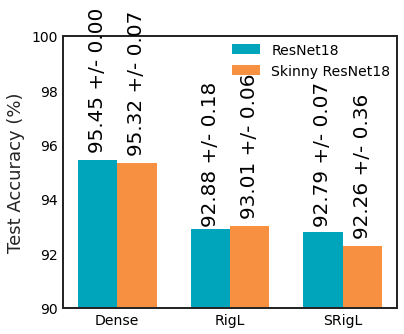

In [38]:
# Skinny ResNet


def skinny_resnet_plot(model_name, ids, dense_benchmark_value, ylim=[0.9,1.0], xlim=[0.49,1.0], plot_error_bars: bool = True, x_ticks = None):
    # _BENCHMARK_VALUE = 0.9506

    plot_df = df.loc[ids].copy(deep=True)
    plot_df["rigl.dynamic_ablation"].fillna(False, inplace=True)
    plot_df = plot_df.loc[plot_df["state"] == "finished"]
    plot_df["sparsity"] = (1-plot_df["rigl.dense_allocation"])*100
    plot_df["sparsity"].fillna(-1, inplace=True)
    plot_df["best_accuracy"] = plot_df["best_accuracy"]*100
    fig, ax = plt.subplots(figsize=_FIG_SIZE)
    
    # Dense, RigL, SRigL, 
    wide_means =[]
    wide_pm =[]
    skinny_means = []
    skinny_pm = []
    df_slice = plot_df.loc[plot_df["sparsity"]== -1]
    agg_results = get_confidence_bounds_df(df_slice, target_col="best_accuracy")
    wide_means.append(dense_benchmark_value*100)
    wide_pm.append((0,0))
    skinny_means.append(agg_results["mean"].item())
    skinny_pm.append((agg_results["mean"].item()-agg_results["lower_bound"].item(), agg_results["mean"].item()-agg_results["upper_bound"].item()))
    
     # rigl
    df_slice = plot_df.loc[(plot_df["rigl.const_fan_in"] == False) & (plot_df["sparsity"] != -1) & (plot_df["model"] != "skinny_resnet18")]
    agg_results = get_confidence_bounds_df(df_slice, target_col="best_accuracy")
    wide_means.append(agg_results["mean"].item())
    wide_pm.append((agg_results["mean"].item()-agg_results["lower_bound"].item(), agg_results["mean"].item()-agg_results["upper_bound"].item()))
    
    df_slice = plot_df.loc[(plot_df["rigl.const_fan_in"] == False) & (plot_df["sparsity"] != -1) & (plot_df["model"] == "skinny_resnet18")]
    agg_results = get_confidence_bounds_df(df_slice, target_col="best_accuracy")
    skinny_means.append(agg_results["mean"].item())
    skinny_pm.append((agg_results["mean"].item()-agg_results["lower_bound"].item(), agg_results["mean"].item()-agg_results["upper_bound"].item()))
    
    # const_fan
    df_slice = plot_df.loc[(plot_df["rigl.const_fan_in"] == True) & (plot_df["sparsity"] != -1) & (plot_df["model"] != "skinny_resnet18")]
    agg_results = get_confidence_bounds_df(df_slice, target_col="best_accuracy")
    wide_means.append(agg_results["mean"].item())
    wide_pm.append((agg_results["mean"].item()-agg_results["lower_bound"].item(), agg_results["mean"].item()-agg_results["upper_bound"].item()))
    
    df_slice = plot_df.loc[(plot_df["rigl.const_fan_in"] == True) & (plot_df["sparsity"] != -1) & (plot_df["model"] == "skinny_resnet18")]
    agg_results = get_confidence_bounds_df(df_slice, target_col="best_accuracy")
    skinny_means.append(agg_results["mean"].item())
    skinny_pm.append((agg_results["mean"].item()-agg_results["lower_bound"].item(), agg_results["mean"].item()-agg_results["upper_bound"].item()))
    
    x=np.arange(3)
    labels = ["Dense", "RigL", "SRigL"]
    width=.35 
    resnet18_bar = ax.bar(
        x=x-width/2,
        height=wide_means,
        width=width,
        label="ResNet18",
        yerr=np.array(wide_pm).T
    )
    print(skinny_means)
    skinny_resnet18_bar = ax.bar(
        x=x+width/2,
        height=skinny_means,
        width=width,
        label="Skinny ResNet18"
    )
    
    ax.set_ylabel('Test Accuracy (%)')
    ax.set_xticks(x, labels)
    ax.legend()
    ax.bar_label(resnet18_bar, labels = [f"{mean:.2f} +/- {error[0]:.2f}" for mean, error in list(zip(wide_means, wide_pm))], padding=8, fmt="%G", rotation=90, label_type="edge")
    ax.bar_label(skinny_resnet18_bar, labels = [f"{mean:.2f} +/- {error[0]:.2f}" for mean, error in list(zip(skinny_means, skinny_pm))], padding=8, fmt="%G", rotation=90, label_type="edge")

    ax.legend(bbox_to_anchor=(1,1))
    ax.set_ylim(ylim)
    fig_name = f"skinny_resnet_results"
    fig.savefig(f"../fig/{model_name}.png", dpi=600, bbox_inches="tight")
    fig.savefig(f"../fig/{model_name}.svg",format="svg", bbox_inches="tight")
    fig.savefig(f"../fig/{model_name}.pdf",format="pdf", bbox_inches="tight")
    return fig

params=dict(
    ids = skinny_resnet.index.to_list(),
    model_name ="../fig/skinny_resnet",
    dense_benchmark_value = _RESNET18_BENCHMARK,
    ylim=[90,100],
    # xlim=[89,100]
)

fig = skinny_resnet_plot(**params)
fig.show()


In [39]:
def get_srigl_imagenet_results(df):
    df = df.copy(deep=True)
    df["best_accuracy"] = df["best_accuracy"] * 100
    df["dense_allocation"] = df["rigl.dense_allocation"]
    results = []
    # for d in df["dense_allocation"].unique():
    df = get_confidence_bounds_df(df,target_col="best_accuracy", x_col="dense_allocation")
    return df  

srigl_imagenet_results = get_srigl_imagenet_results(imagenet_x1)

_SRIGL_PARAMS["method"] = ["SRigL" for _ in list(range(len(_SRIGL_PARAMS)))]
srigl_imagenet_results = srigl_imagenet_results.merge(right=_SRIGL_PARAMS, on="dense_allocation", how="inner")
_SR_STE_PARAMS["method"] = ["SR-STE" for _ in list(range(len(_SR_STE_PARAMS)))]
inference_flops = _SRIGL_PARAMS.loc[_SRIGL_PARAMS["dense_allocation"].isna()]["flops"].item()
training_flops = _SRIGL_PARAMS.loc[_SRIGL_PARAMS["dense_allocation"].isna()]["training_flops"].item()
_SR_STE_PARAMS["normalized_flops"] = _SR_STE_PARAMS["flops"]/inference_flops
_SR_STE_PARAMS["training_flops"] = training_flops*2/3
_SR_STE_PARAMS["normalized_training_flops"] = _SR_STE_PARAMS["training_flops"]/training_flops
params = pd.concat([srigl_imagenet_results,_SR_STE_PARAMS])
params


/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,dense_allocation,mean,lower_bound,upper_bound,Unnamed: 0,rigl.dense_allocation,flops,model,params,normalized_flops,training_flops,normalized_training_flops,method,parameters,dense_params,macs
0,0.0500,69.183999,NaN,NaN,2.0,0.05,1.006217e+09,resnet50,2099700.0,0.122867,3.018652e+09,0.122867,SRigL,NaN,NaN,NaN
1,0.1000,72.707999,NaN,NaN,4.0,0.10,1.988961e+09,resnet50,3374716.0,0.242868,5.966884e+09,0.242868,SRigL,NaN,NaN,NaN
2,0.0100,51.547998,NaN,NaN,1.0,0.01,2.101481e+08,resnet50,1079578.0,0.025661,6.304442e+08,0.025661,SRigL,NaN,NaN,NaN
3,0.2000,75.011998,NaN,NaN,5.0,0.20,3.395292e+09,resnet50,5920909.0,0.414592,1.018587e+10,0.414592,SRigL,NaN,NaN,NaN
0,0.0625,71.500000,71.5,71.5,NaN,NaN,8.800000e+08,NaN,NaN,0.107455,1.637896e+10,0.666667,SR-STE,3520000.0,25557032.0,4.400000e+08
1,0.2500,76.200000,76.2,76.2,NaN,NaN,2.340000e+09,NaN,NaN,0.285732,1.637896e+10,0.666667,SR-STE,7930000.0,25557032.0,1.170000e+09


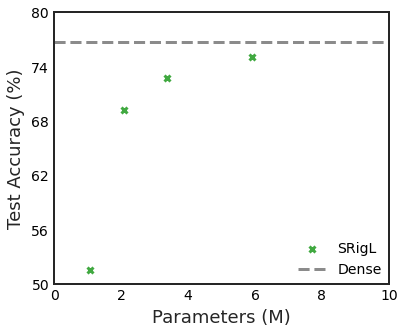

In [40]:
## Acc vs. Params:


# DF with columns: params, dense_params, mean, upper_bound, lower_bound, method

def get_accuracy_vs_params_plot(figure_name, plot_df, dense_benchmark_value, ylim=[0.9,1.0], xlim=[0.49,1.0], plot_error_bars: bool = False, x_ticks = None):
    
    plot_df = plot_df.copy(deep=True)
    if "params" not in plot_df:
        plot_df["params"] = plot_df["parameters"]
    plot_df["params"] = plot_df["params"]/1e6
    plot_df = plot_df.sort_values(by="params")
    fig, ax = plt.subplots(figsize=_FIG_SIZE)
    
    method="SRigL"
    color=_COLORS[2]
    df_slice = plot_df.loc[plot_df["method"]==method]
    ax.scatter(df_slice["params"], df_slice['mean'], color=color,label=method, **_MEAN_MARKER)
    
    # method="SR-STE"
    # color = sns.color_palette("tab10").as_hex()[5]
    # df_slice = plot_df.loc[plot_df["method"]==method]
    # ax.scatter(df_slice["params"], df_slice['mean'],color=color, label=method, **_MEAN_MARKER)

    ax.plot(xlim, [_IMAGENET_BENCHMARK*100,_IMAGENET_BENCHMARK*100], "--",  label="Dense", color=_COLORS[-3], alpha=0.9)
    plt.xlabel('Parameters (M)')
    plt.ylabel('Test Accuracy (%)')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc="lower right")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    
    tick_spaces=5
    y_tick_eps = (max(ylim) - min(ylim))/tick_spaces
    y_ticks = [min(ylim)+y_tick_eps*x for x in range(tick_spaces+1)]
    ax.set_yticks(y_ticks)
    if x_ticks is not None:
        ax.set_xticks(x_ticks)
    # ax.set_yscale("log")
    fig.savefig(f"../fig/{figure_name}.png", dpi=600, bbox_inches="tight")
    fig.savefig(f"../fig/{figure_name}.svg",format="svg", bbox_inches="tight")
    fig.savefig(f"../fig/{figure_name}.pdf",format="pdf", bbox_inches="tight")
    return fig

fig_params=dict(
    figure_name="acc-vs-param",
    plot_df=params,
    dense_benchmark_value=_IMAGENET_BENCHMARK,
    ylim=[50,80],
    xlim=[0,10],
)

fig = get_accuracy_vs_params_plot(**fig_params)
fig.show()


In [41]:
params


,dense_allocation,mean,lower_bound,upper_bound,Unnamed: 0,rigl.dense_allocation,flops,model,params,normalized_flops,training_flops,normalized_training_flops,method,parameters,dense_params,macs
0,0.0500,69.183999,NaN,NaN,2.0,0.05,1.006217e+09,resnet50,2099700.0,0.122867,3.018652e+09,0.122867,SRigL,NaN,NaN,NaN
1,0.1000,72.707999,NaN,NaN,4.0,0.10,1.988961e+09,resnet50,3374716.0,0.242868,5.966884e+09,0.242868,SRigL,NaN,NaN,NaN
2,0.0100,51.547998,NaN,NaN,1.0,0.01,2.101481e+08,resnet50,1079578.0,0.025661,6.304442e+08,0.025661,SRigL,NaN,NaN,NaN
3,0.2000,75.011998,NaN,NaN,5.0,0.20,3.395292e+09,resnet50,5920909.0,0.414592,1.018587e+10,0.414592,SRigL,NaN,NaN,NaN
0,0.0625,71.500000,71.5,71.5,NaN,NaN,8.800000e+08,NaN,NaN,0.107455,1.637896e+10,0.666667,SR-STE,3520000.0,25557032.0,4.400000e+08
1,0.2500,76.200000,76.2,76.2,NaN,NaN,2.340000e+09,NaN,NaN,0.285732,1.637896e+10,0.666667,SR-STE,7930000.0,25557032.0,1.170000e+09


   dense_allocation       mean  lower_bound  upper_bound  Unnamed: 0  \
0            0.0500  69.183999          NaN          NaN         2.0   
1            0.1000  72.707999          NaN          NaN         4.0   
2            0.0100  51.547998          NaN          NaN         1.0   
3            0.2000  75.011998          NaN          NaN         5.0   
0            0.0625  71.500000         71.5         71.5         NaN   
1            0.2500  76.200000         76.2         76.2         NaN   

   rigl.dense_allocation         flops     model     params  normalized_flops  \
0                   0.05  1.006217e+09  resnet50  2099700.0          0.122867   
1                   0.10  1.988961e+09  resnet50  3374716.0          0.242868   
2                   0.01  2.101481e+08  resnet50  1079578.0          0.025661   
3                   0.20  3.395292e+09  resnet50  5920909.0          0.414592   
0                    NaN  8.800000e+08       NaN        NaN          0.107455   
1        

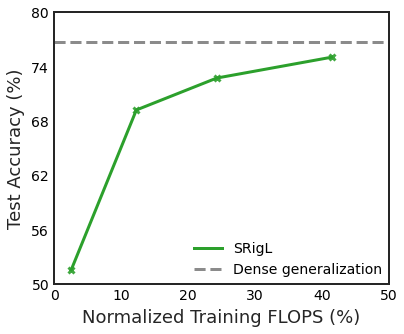

In [42]:
## Acc vs. Params:


# DF with columns: flops, dense_flops, mean, upper_bound, lower_bound, method

def get_accuracy_vs_flops_plot(figure_name, plot_df, dense_benchmark_value, ylim=[0.9,1.0], xlim=[0.49,1.0], plot_error_bars: bool = False, x_ticks = None):
    # plot_df = plot_df.loc[plot_df["method"].isin(include_methods)]
    plot_df = plot_df.copy(deep=True)
    if "flops" not in plot_df:
        plot_df["flops"] = plot_df["parameters"]
    plot_df["Inference FLOPs"] = plot_df["flops"]/dense_benchmark_value*100
    plot_df["Training FLOPs"] = plot_df["normalized_training_flops"]*100
    print(plot_df)
    plot_df = plot_df.sort_values(by="Inference FLOPs")
    fig, ax = plt.subplots(figsize=_FIG_SIZE)
    
    # method="SRigL - Inference FLOPs"
    # color=_COLORS[2]
    # df_slice = plot_df.loc[plot_df["method"]=="SRigL"]
    # ax.scatter(df_slice["Inference FLOPs"], df_slice['mean'], color=color,label=method, **_MEAN_MARKER)
    
    plot_df = plot_df.sort_values(by="Training FLOPs")
    method="SRigL"
    color=_COLORS[2]
    df_slice = plot_df.loc[plot_df["method"]=="SRigL"]
    ax.plot(df_slice["Training FLOPs"], df_slice['mean'], color=color, label=method, marker=None)
    ax.scatter(df_slice["Training FLOPs"], df_slice['mean'], color=color, label=None, **_MEAN_MARKER)
    
    # method="SR-STE"
    # color = sns.color_palette("tab10").as_hex()[5]
    # df_slice = plot_df.loc[plot_df["method"]==method]
    # ax.scatter(df_slice["flops"], df_slice['mean'],color=color, label=method, **_MEAN_MARKER)

    ax.plot(xlim, [_IMAGENET_BENCHMARK*100,_IMAGENET_BENCHMARK*100], "--",  label="Dense generalization", color=_COLORS[-3], alpha=0.9)
    plt.xlabel('Normalized Training FLOPS (%)')
    plt.ylabel('Test Accuracy (%)')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc="best", framealpha=0)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    
    tick_spaces=5
    y_tick_eps = (max(ylim) - min(ylim))/tick_spaces
    y_ticks = [min(ylim)+y_tick_eps*x for x in range(tick_spaces+1)]
    ax.set_yticks(y_ticks)
    if x_ticks is not None:
        ax.set_xticks(x_ticks)
    # ax.set_yscale("log")
    fig.savefig(f"../fig/{figure_name}.png", dpi=600, bbox_inches="tight")
    fig.savefig(f"../fig/{figure_name}.svg",format="svg", bbox_inches="tight")
    fig.savefig(f"../fig/{figure_name}.pdf",format="pdf", bbox_inches="tight")
    return fig

# dense_flops = 8.189482496e9
dense_flops=8.2e9

fig_params=dict(
    figure_name="acc-vs-flops",
    plot_df=params,
    dense_benchmark_value=dense_flops,
    ylim=[50,80],
    xlim=[0,50],
)

fig = get_accuracy_vs_flops_plot(**fig_params)
fig.show()


   dense_allocation       mean  lower_bound  upper_bound  Unnamed: 0  \
0            0.0500  69.183999          NaN          NaN         2.0   
1            0.1000  72.707999          NaN          NaN         4.0   
2            0.0100  51.547998          NaN          NaN         1.0   
3            0.2000  75.011998          NaN          NaN         5.0   
0            0.0625  71.500000         71.5         71.5         NaN   
1            0.2500  76.200000         76.2         76.2         NaN   

   rigl.dense_allocation         flops     model     params  normalized_flops  \
0                   0.05  1.006217e+09  resnet50  2099700.0         12.286701   
1                   0.10  1.988961e+09  resnet50  3374716.0         24.286779   
2                   0.01  2.101481e+08  resnet50  1079578.0          2.566073   
3                   0.20  3.395292e+09  resnet50  5920909.0         41.459172   
0                    NaN  8.800000e+08       NaN        NaN         10.745490   
1        

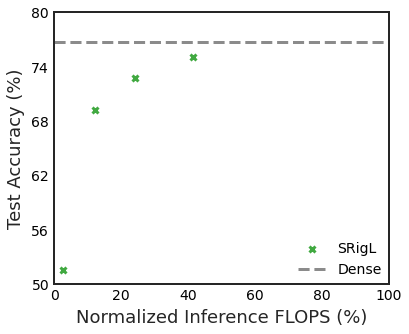

In [43]:
## Acc vs. Params:


# DF with columns: flops, dense_flops, mean, upper_bound, lower_bound, method

def get_accuracy_vs_normalized_flops_plot(x_col, figure_name, plot_df, dense_benchmark_value,x_axis_label, ylim=[0.9,1.0], xlim=[0.49,1.0], plot_error_bars: bool = False, x_ticks = None, ):
    
    plot_df = plot_df.copy(deep=True)
    plot_df[x_col] = plot_df[x_col]*100
    print(plot_df)
    plot_df = plot_df.sort_values(by=x_col)
    fig, ax = plt.subplots(figsize=_FIG_SIZE)
    
    method="SRigL"
    color=_COLORS[2]
    df_slice = plot_df.loc[plot_df["method"]==method]
    ax.scatter(df_slice[x_col], df_slice['mean'], color=color,label=method, **_MEAN_MARKER)
    
    # method="SR-STE"
    # color = sns.color_palette("tab10").as_hex()[5]
    # df_slice = plot_df.loc[plot_df["method"]==method]
    # ax.scatter(df_slice[x_col], df_slice['mean'],color=color, label=method, **_MEAN_MARKER)

    ax.plot(xlim, [_IMAGENET_BENCHMARK*100,_IMAGENET_BENCHMARK*100], "--",  label="Dense", color=_COLORS[-3], alpha=0.9)
    plt.xlabel(x_axis_label)
    plt.ylabel('Test Accuracy (%)')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc="lower right", framealpha=0)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    
    tick_spaces=5
    y_tick_eps = (max(ylim) - min(ylim))/tick_spaces
    y_ticks = [min(ylim)+y_tick_eps*x for x in range(tick_spaces+1)]
    ax.set_yticks(y_ticks)
    if x_ticks is not None:
        ax.set_xticks(x_ticks)
    # ax.set_yscale("log")
    fig.savefig(f"../fig/{figure_name}.png", dpi=600, bbox_inches="tight")
    fig.savefig(f"../fig/{figure_name}.svg",format="svg", bbox_inches="tight")
    fig.savefig(f"../fig/{figure_name}.pdf",format="pdf", bbox_inches="tight")
    return fig

# dense_flops = 8.189482496e9
# dense_flops=8.2e9
inference_flops = _SRIGL_PARAMS.loc[_SRIGL_PARAMS["dense_allocation"].isna()]["flops"].item()
training_flops = _SRIGL_PARAMS.loc[_SRIGL_PARAMS["dense_allocation"].isna()]["training_flops"].item()


fig_params=dict(
    x_col="normalized_flops",
    figure_name="acc-vs-normalized-inference-flops",
    plot_df=params,
    dense_benchmark_value=inference_flops,
    ylim=[50,80],
    xlim=[0,100], 
    x_axis_label=f"Normalized Inference FLOPS (%)"
)

fig = get_accuracy_vs_normalized_flops_plot(**fig_params)
fig.show()


In [44]:
display(params)


,dense_allocation,mean,lower_bound,upper_bound,Unnamed: 0,rigl.dense_allocation,flops,model,params,normalized_flops,training_flops,normalized_training_flops,method,parameters,dense_params,macs
0,0.0500,69.183999,NaN,NaN,2.0,0.05,1.006217e+09,resnet50,2099700.0,0.122867,3.018652e+09,0.122867,SRigL,NaN,NaN,NaN
1,0.1000,72.707999,NaN,NaN,4.0,0.10,1.988961e+09,resnet50,3374716.0,0.242868,5.966884e+09,0.242868,SRigL,NaN,NaN,NaN
2,0.0100,51.547998,NaN,NaN,1.0,0.01,2.101481e+08,resnet50,1079578.0,0.025661,6.304442e+08,0.025661,SRigL,NaN,NaN,NaN
3,0.2000,75.011998,NaN,NaN,5.0,0.20,3.395292e+09,resnet50,5920909.0,0.414592,1.018587e+10,0.414592,SRigL,NaN,NaN,NaN
0,0.0625,71.500000,71.5,71.5,NaN,NaN,8.800000e+08,NaN,NaN,0.107455,1.637896e+10,0.666667,SR-STE,3520000.0,25557032.0,4.400000e+08
1,0.2500,76.200000,76.2,76.2,NaN,NaN,2.340000e+09,NaN,NaN,0.285732,1.637896e+10,0.666667,SR-STE,7930000.0,25557032.0,1.170000e+09


   dense_allocation       mean  lower_bound  upper_bound  Unnamed: 0  \
0              0.05  69.183999          NaN          NaN         2.0   
1              0.10  72.707999          NaN          NaN         4.0   
2              0.01  51.547998          NaN          NaN         1.0   
3              0.20  75.011998          NaN          NaN         5.0   

   rigl.dense_allocation         flops     model     params  normalized_flops  \
0                   0.05  1.006217e+09  resnet50  2099700.0          0.122867   
1                   0.10  1.988961e+09  resnet50  3374716.0          0.242868   
2                   0.01  2.101481e+08  resnet50  1079578.0          0.025661   
3                   0.20  3.395292e+09  resnet50  5920909.0          0.414592   

   training_flops  normalized_training_flops method  parameters  dense_params  \
0    3.018652e+09                  12.286701  SRigL         NaN           NaN   
1    5.966884e+09                  24.286779  SRigL         NaN        

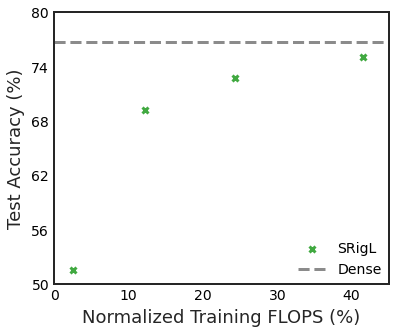

In [45]:
training_flops = _SRIGL_PARAMS.loc[_SRIGL_PARAMS["dense_allocation"].isna()]["training_flops"].item()
srigl_params_only = params.loc[params["method"]=="SRigL"]

fig_params=dict(
    x_col="normalized_training_flops",
    figure_name="acc-vs-normalized-training-flops",
    plot_df=srigl_params_only,
    dense_benchmark_value=training_flops,
    ylim=[50,80],
    xlim=[0,45],
    x_axis_label=f"Normalized Training FLOPS (%)"
)

fig = get_accuracy_vs_normalized_flops_plot(**fig_params)
fig.show()


In [46]:
params = params.sort_values(by="rigl.dense_allocation", ascending=False)
params["sparsity"] = (1-params["rigl.dense_allocation"])*100
for idx, row in params.iterrows():
    print(f"{row['sparsity']}")
    print(f"{row['method']}")
    print(f"${row['training_flops']/1e9:.2f}$")
    print(f"${row['flops']/1e9:.2f}$")


80.0
SRigL
$10.19$
$3.40$
90.0
SRigL
$5.97$
$1.99$
95.0
SRigL
$3.02$
$1.01$
99.0
SRigL
$0.63$
$0.21$
nan
SR-STE
$16.38$
$0.88$
nan
SR-STE
$16.38$
$2.34$


In [47]:
import plotly.express as px


imagenet_x2.index.to_list()


['26ypkzes', 'uydgvx31', '2umeh1wv', '23bqr8zs']

In [48]:
imagenet_x1


,Annotated Predictions 0._type,Annotated Predictions 0.format,Annotated Predictions 0.height,Annotated Predictions 0.path,Annotated Predictions 0.sha256,Annotated Predictions 0.size,Annotated Predictions 0.width,Annotated Predictions 1._type,Annotated Predictions 1.format,Annotated Predictions 1.height,...,z-self_attention-Max-Grad-Per-Filter.values,z-self_attention-Max-Inactive_Grad,z-self_attention-Max-Inactive_Weight,z-self_attention-Max-Weight-Per-Filter._type,z-self_attention-Max-Weight-Per-Filter.bins,z-self_attention-Max-Weight-Per-Filter.values,z-self_attention-Weight-Dist._type,z-self_attention-Weight-Dist.bins,z-self_attention-Weight-Dist.values,z-self_attention_total-active-neurons
id,,,,,,,,,,,,,,,,,,,,,
1oid9nmo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14so3lij,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2brxovy4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4zbwd4nt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# min sal per layer
min_sal_per_layer = pd.DataFrame(
    {'rigl.dense_allocation': {0: 0.01,
  1: 0.01,
  2: 0.01,
  3: 0.01,
  4: 0.01,
  5: 0.01,
  6: 0.01,
  7: 0.01,
  8: 0.01,
  9: 0.01,
  10: 0.01,
  11: 0.01,
  12: 0.01,
  13: 0.01,
  14: 0.01,
  15: 0.01,
  16: 0.01,
  17: 0.01,
  18: 0.01,
  19: 0.01,
  20: 0.01,
  21: 0.01,
  22: 0.01,
  23: 0.01,
  24: 0.01,
  25: 0.01,
  26: 0.01,
  27: 0.01,
  28: 0.01,
  29: 0.01,
  30: 0.01,
  31: 0.01,
  32: 0.01,
  33: 0.01,
  34: 0.01,
  35: 0.01,
  36: 0.01,
  37: 0.01,
  38: 0.01,
  39: 0.01,
  40: 0.01,
  41: 0.01,
  42: 0.01,
  43: 0.01,
  44: 0.01,
  45: 0.01,
  46: 0.01,
  47: 0.01,
  48: 0.01,
  49: 0.01,
  50: 0.01,
  51: 0.01,
  52: 0.01},
 'min_sal_per_layer': {0: 1,
  1: 2,
  2: 3,
  3: 1,
  4: 1,
  5: 7,
  6: 3,
  7: 1,
  8: 7,
  9: 3,
  10: 1,
  11: 4,
  12: 2,
  13: 1,
  14: 2,
  15: 7,
  16: 2,
  17: 1,
  18: 7,
  19: 2,
  20: 1,
  21: 7,
  22: 2,
  23: 1,
  24: 4,
  25: 2,
  26: 1,
  27: 2,
  28: 7,
  29: 2,
  30: 1,
  31: 7,
  32: 2,
  33: 1,
  34: 7,
  35: 2,
  36: 1,
  37: 7,
  38: 2,
  39: 1,
  40: 7,
  41: 2,
  42: 1,
  43: 4,
  44: 2,
  45: 1,
  46: 2,
  47: 7,
  48: 2,
  49: 1,
  50: 7,
  51: 2,
  52: 1},
 'layer_name': {0: 'conv1',
  1: 'layer1.0.conv1',
  2: 'layer1.0.conv2',
  3: 'layer1.0.conv3',
  4: 'layer1.0.downsample.0',
  5: 'layer1.1.conv1',
  6: 'layer1.1.conv2',
  7: 'layer1.1.conv3',
  8: 'layer1.2.conv1',
  9: 'layer1.2.conv2',
  10: 'layer1.2.conv3',
  11: 'layer2.0.conv1',
  12: 'layer2.0.conv2',
  13: 'layer2.0.conv3',
  14: 'layer2.0.downsample.0',
  15: 'layer2.1.conv1',
  16: 'layer2.1.conv2',
  17: 'layer2.1.conv3',
  18: 'layer2.2.conv1',
  19: 'layer2.2.conv2',
  20: 'layer2.2.conv3',
  21: 'layer2.3.conv1',
  22: 'layer2.3.conv2',
  23: 'layer2.3.conv3',
  24: 'layer3.0.conv1',
  25: 'layer3.0.conv2',
  26: 'layer3.0.conv3',
  27: 'layer3.0.downsample.0',
  28: 'layer3.1.conv1',
  29: 'layer3.1.conv2',
  30: 'layer3.1.conv3',
  31: 'layer3.2.conv1',
  32: 'layer3.2.conv2',
  33: 'layer3.2.conv3',
  34: 'layer3.3.conv1',
  35: 'layer3.3.conv2',
  36: 'layer3.3.conv3',
  37: 'layer3.4.conv1',
  38: 'layer3.4.conv2',
  39: 'layer3.4.conv3',
  40: 'layer3.5.conv1',
  41: 'layer3.5.conv2',
  42: 'layer3.5.conv3',
  43: 'layer4.0.conv1',
  44: 'layer4.0.conv2',
  45: 'layer4.0.conv3',
  46: 'layer4.0.downsample.0',
  47: 'layer4.1.conv1',
  48: 'layer4.1.conv2',
  49: 'layer4.1.conv3',
  50: 'layer4.2.conv1',
  51: 'layer4.2.conv2',
  52: 'layer4.2.conv3'}}
)


In [50]:
min_sal_per_layer.head()


,rigl.dense_allocation,min_sal_per_layer,layer_name
0,0.01,1,conv1
1,0.01,2,layer1.0.conv1
2,0.01,3,layer1.0.conv2
3,0.01,1,layer1.0.conv3
4,0.01,1,layer1.0.downsample.0


In [51]:
min_sal_per_layer.layer_name.unique()


array(['conv1', 'layer1.0.conv1', 'layer1.0.conv2', 'layer1.0.conv3',
       'layer1.0.downsample.0', 'layer1.1.conv1', 'layer1.1.conv2',
       'layer1.1.conv3', 'layer1.2.conv1', 'layer1.2.conv2',
       'layer1.2.conv3', 'layer2.0.conv1', 'layer2.0.conv2',
       'layer2.0.conv3', 'layer2.0.downsample.0', 'layer2.1.conv1',
       'layer2.1.conv2', 'layer2.1.conv3', 'layer2.2.conv1',
       'layer2.2.conv2', 'layer2.2.conv3', 'layer2.3.conv1',
       'layer2.3.conv2', 'layer2.3.conv3', 'layer3.0.conv1',
       'layer3.0.conv2', 'layer3.0.conv3', 'layer3.0.downsample.0',
       'layer3.1.conv1', 'layer3.1.conv2', 'layer3.1.conv3',
       'layer3.2.conv1', 'layer3.2.conv2', 'layer3.2.conv3',
       'layer3.3.conv1', 'layer3.3.conv2', 'layer3.3.conv3',
       'layer3.4.conv1', 'layer3.4.conv2', 'layer3.4.conv3',
       'layer3.5.conv1', 'layer3.5.conv2', 'layer3.5.conv3',
       'layer4.0.conv1', 'layer4.0.conv2', 'layer4.0.conv3',
       'layer4.0.downsample.0', 'layer4.1.conv1', 'laye

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: "DejaVu Sans"
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: "DejaVu Sans"


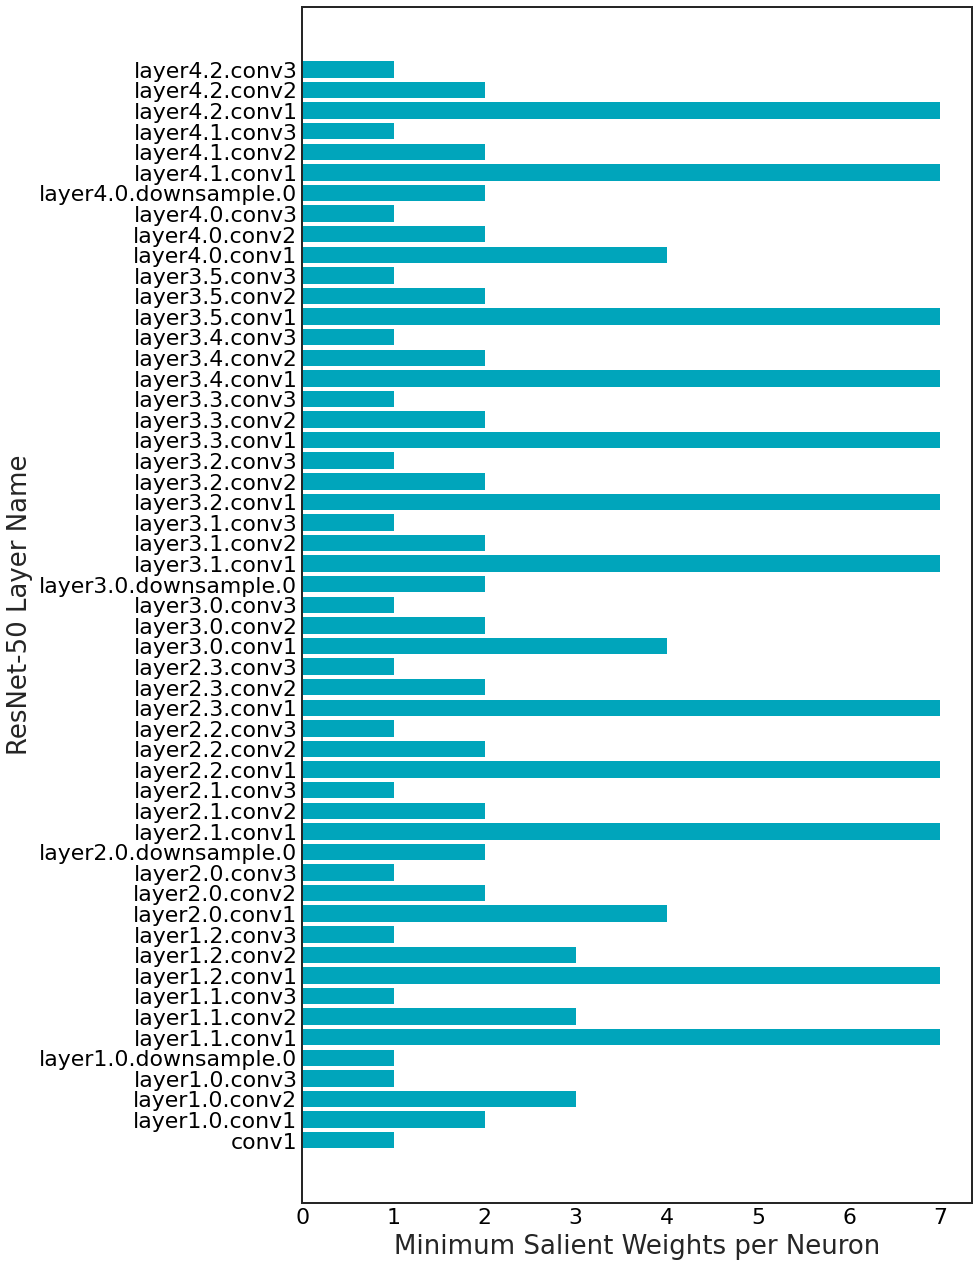

In [52]:
fig, ax = plt.subplots(figsize=(12,22))
plot_df = min_sal_per_layer
ax.barh(plot_df["layer_name"], plot_df["min_sal_per_layer"])
plt.xlabel("Minimum Salient Weights per Neuron", fontsize=26)
plt.ylabel('ResNet-50 Layer Name',  fontsize=26)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc="lower right", framealpha=0)
figure_name = "layer-vs-min-sal"
# ax.set_yscale("log")
fig.savefig(f"../fig/{figure_name}.png", dpi=600, bbox_inches="tight")
fig.savefig(f"../fig/{figure_name}.svg",format="svg", bbox_inches="tight")
fig.savefig(f"../fig/{figure_name}.pdf",format="pdf", bbox_inches="tight")


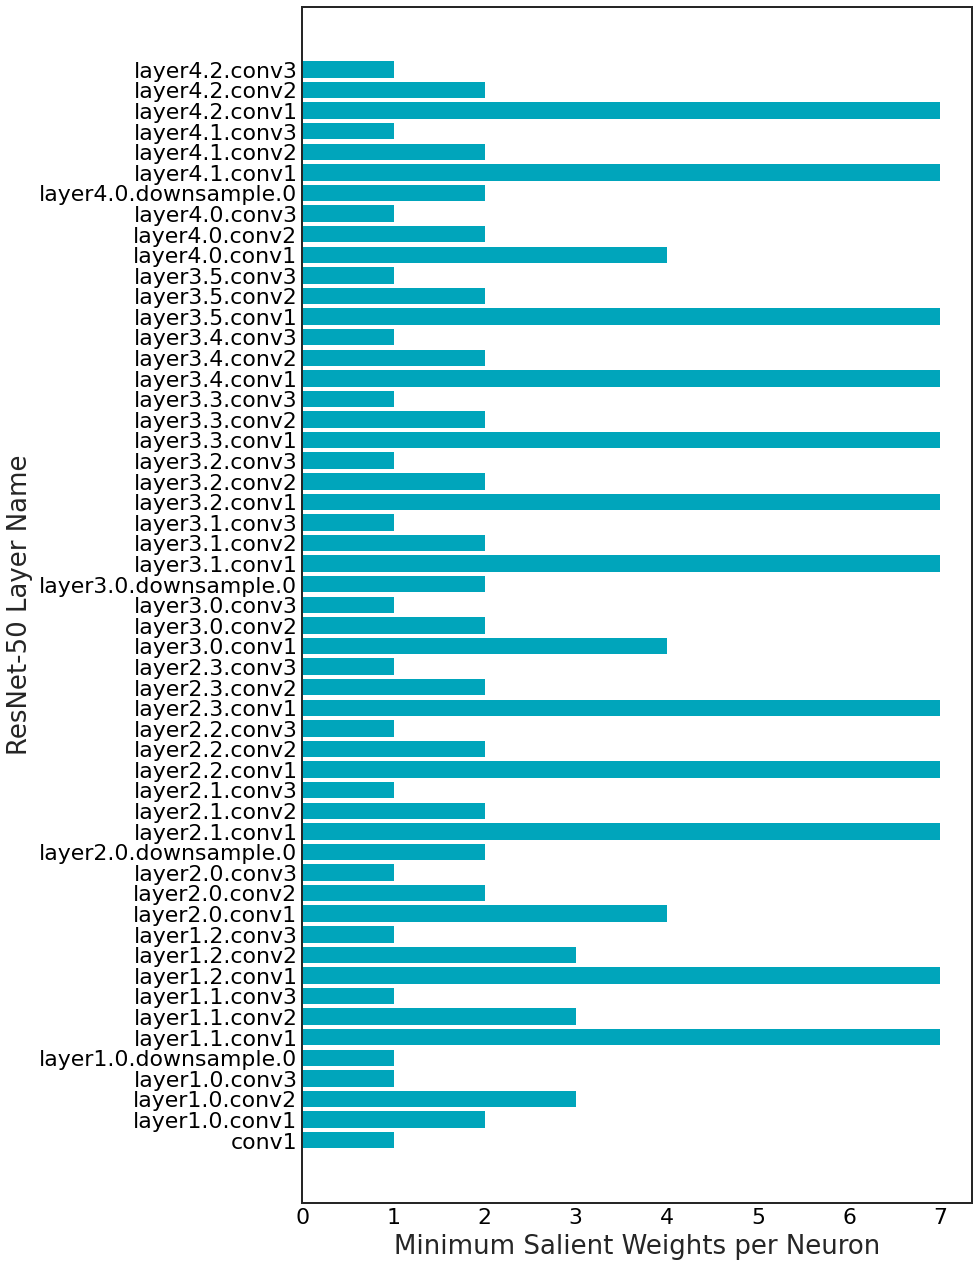

In [53]:
fig


In [54]:
## ITOP

vit_results[["rigl.dense_allocation", "best_accuracy", "rigl.const_fan_in", "rigl.dynamic_ablation", "ITOP Rate"]]


,rigl.dense_allocation,best_accuracy,rigl.const_fan_in,rigl.dynamic_ablation,ITOP Rate
id,,,,,
1ng3llec,0.1,0.71264,True,False,0.696621
2vns1fqj,0.2,0.73496,True,False,0.923734
3q0koovk,0.2,0.77472,True,True,0.514768
nrblbn15,0.1,0.76004,True,True,0.365042
3p6dparl,0.1,0.76390,False,True,0.473659
1ige8ylm,0.2,0.77878,False,True,0.742746


/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


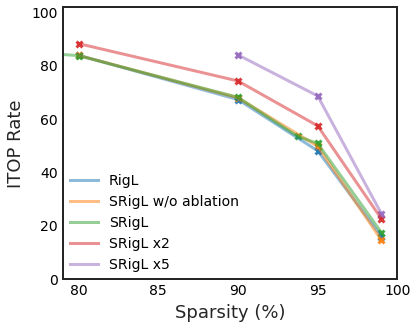

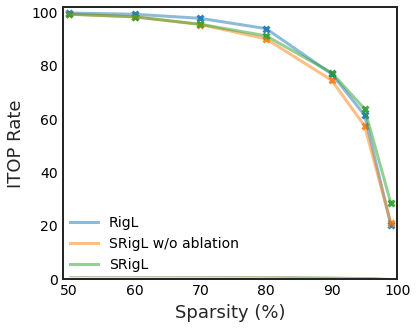

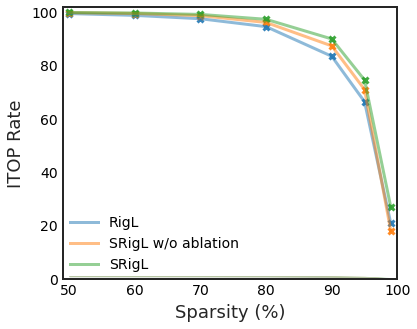

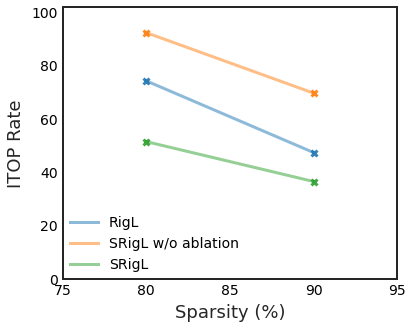

In [55]:
def plot_ITOP(df, model_name="", ylim=[90,100], xlim=[49,100]):
    _TARGET_COL="ITOP Rate"
    df=df.copy(deep=True)
    df = df.sort_values(by="rigl.dense_allocation")
    df["sparsity"] = (1-df["rigl.dense_allocation"])*100
    plot_dfs = []
    fig, ax = plt.subplots(figsize=_FIG_SIZE)

    for idx, (epoch, fan_in, dynamic_ablation) in enumerate(df.groupby(["epoch", "rigl.const_fan_in", "rigl.dynamic_ablation"], dropna=False).count().index.unique()): 
        df_slice = df.loc[(df["rigl.const_fan_in"] == fan_in) & (df["rigl.dynamic_ablation"] == dynamic_ablation) & (df["epoch"] == epoch)]    
        name, color = series_name_plot_mapper(fan_in, dynamic_ablation, df["epoch"].unique(), int(epoch))
        agg_results = get_confidence_bounds_df(df_slice, target_col=_TARGET_COL)
        agg_results['mean'] = agg_results['mean'] * 100
        # display(agg_results)
        if _PLOT_FUNCT=="scatter":
            ax.scatter(
                agg_results["sparsity"], agg_results["mean"], label=name, color=color, **_MEAN_MARKER
            )
            yerr= [a["upper_bound"]-a["mean"] for _,a in agg_results.iterrows()]
            ax.errorbar(agg_results["sparsity"], agg_results["mean"], yerr=yerr,fmt="none", color=color, elinewidth=0.5, capsize=3)
        else:
            ax.plot(
                agg_results["sparsity"], agg_results["mean"], label=name, color=color, marker=None, alpha=0.50
            )
            ax.scatter(
                agg_results["sparsity"], agg_results["mean"], label=None, color=color, **_MEAN_MARKER,
            )
            
            # ax.plot(
            #     agg_results["sparsity"], agg_results["mean"], label=name, color=color, **_MEAN_MARKER
            # )
            ax.fill_between(
                agg_results["sparsity"],
                agg_results["upper_bound"],
                agg_results["lower_bound"],
                color=color,
                alpha=0.20
            )
            # ax.scatter(
            #     df_slice["sparsity"], df_slice[_TARGET_COL], marker='o', color=color, alpha=0.5
            # )

    plt.xlabel('Sparsity (%)')
    plt.ylabel('ITOP Rate')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels,  loc="best")
    leg = ax.legend()
    leg.get_frame().set_linewidth(0.0)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    tick_spaces=5
    y_tick_eps = (max(ylim)-2 - min(ylim))/tick_spaces
    y_ticks = [int(min(ylim)+y_tick_eps*x) for x in range(tick_spaces+1)]
    ax.set_yticks(y_ticks)
    # ax.legend(bbox_to_anchor=.35,0.35)
    fig.savefig(f"../fig/{model_name}_itop.png", dpi=600, bbox_inches="tight")
    fig.savefig(f"../fig/{model_name}_itop.svg",format="svg", bbox_inches="tight")
    fig.savefig(f"../fig/{model_name}_itop.pdf",format="pdf", bbox_inches="tight")
    return fig

# sweep_id_ablation_exp = "a2uywunn"
# df.loc[df["sweep_id"]==sweep_id_ablation_exp]["rigl.dense_allocation"].unique()

# resnet18_const_fan_false_ids=df.loc[(df["sweep_id"]==sweep_id_ablation_exp) & (df["model"]=="resnet18")].index.to_list()
# wide_resnet22_const_fan_false_ids=df.loc[(df["sweep_id"]==sweep_id_ablation_exp) & (df["model"]=="wide_resnet22")].index.to_list()
# imagenet_ids = imagenet.loc[imagenet["rigl.dynamic_ablation"] == True].index
# fig = plot_active_neurons_vs_sparsity(imagenet.loc[imagenet_ids], "imagenet", ylim=[58, 100], xlim=[0.79, 1.0])
# fig = plot_active_neurons_vs_sparsity(df.loc[new_high_sparse_ids+resnet18_const_fan_false_ids], "resnet18", ylim=[50, 100])
# fig = plot_active_neurons_vs_sparsity(df.loc[wide_const_fan_ids+wide_resnet22_const_fan_false_ids], "wide_resnet22", ylim=[50, 100])

fig = plot_ITOP(imagenet, "imagenet", ylim=[0, 102], xlim=[79, 100])
fig = plot_ITOP(df.loc[resnet_ids], "resnet18", ylim=[0, 102])
fig = plot_ITOP(df.loc[wide_res_ids], "wide_resnet22", ylim=[0, 102])
fig = plot_ITOP(vit_results, "vit", ylim=[0, 102], xlim=[75,95])


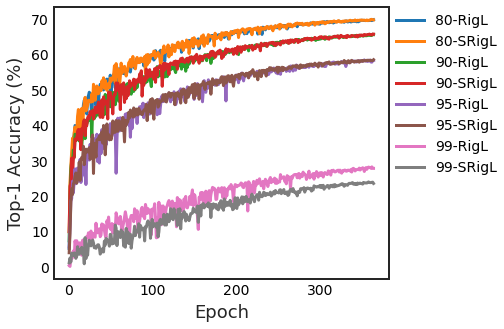

In [56]:
# mobile net plots in prog.
import re
mobilenet_df = pd.read_csv("../mobilenet-large.csv")
col_map = {}
for c in sorted(mobilenet_df.columns):
    if "__" in c:
        continue
    m = re.search(r"\d[.]?\d*", c)
    if m is None:
        continue
    sparsity = m.group()
    sparsity = str(int(100 - float(sparsity)*100))
    if "True" in c:
        const_fan = True
    else:
        const_fan = False
    if const_fan:
        update_name = f"{sparsity}-SRigL"
        # update_name = f"SRigL-{sparsity}"
    else:
        update_name = f"{sparsity}-RigL"
        # update_name = f"RigL-{sparsity}"
    col_map[c] = update_name
    
col_map


mobilenet_df["epoch"] = mobilenet_df.index+1
# mobilenet_df
plot_df = mobilenet_df.rename(columns=col_map)[list(col_map.values())+["epoch"]].dropna()
plot_df = plot_df.reindex(sorted(plot_df.columns, reverse=False), axis=1)


# fig, ax = plt.subplots(figsize=[x*2 for x in _FIG_SIZE])
fig, ax = plt.subplots(figsize=_FIG_SIZE)
for ii, c in enumerate(plot_df.columns):
    if c not in col_map.values():
        continue
    colour = _COLORS[ii]
    ax.plot(plot_df["epoch"], plot_df[c]*100, label=c, color=colour)
ax.legend(bbox_to_anchor=(1,1))
plt.xlabel('Epoch')
plt.ylabel('Top-1 Accuracy (%)')
    # handles, labels = ax.get_legend_handles_labels()
    # ax.legend(handles, labels,  loc="best")
    # leg = ax.legend()
    # leg.get_frame().set_linewidth(0.0)
    # ax.set_ylim(ylim)
    # ax.set_xlim(xlim)
    # tick_spaces=5
    # y_tick_eps = (max(ylim)-2 - min(ylim))/tick_spaces
    # y_ticks = [int(min(ylim)+y_tick_eps*x) for x in range(tick_spaces+1)]
    # ax.set_yticks(y_ticks)
    # # ax.legend(bbox_to_anchor=.35,0.35)
fig.savefig(f"../fig/mobilenet-large-acc-in-prog.png", dpi=600, bbox_inches="tight")
# # fig.savefig(f"../fig/{model_name}_perc_active.svg",format="svg", bbox_inches="tight")
fig.savefig(f"../fig/mobilenet-large-acc-in-prog.pdf",format="pdf", bbox_inches="tight")
    # return fig


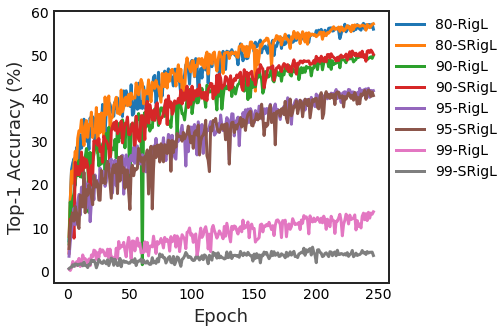

In [57]:
# mobile net plots in prog.

mobilenet_df = pd.read_csv("../mobilenet-small.csv")
col_map = {}
for c in sorted(mobilenet_df.columns):
    if "__" in c:
        continue
    m = re.search(r"\d[.]?\d*", c)
    if m is None:
        continue
    sparsity = m.group()
    sparsity = str(int(100 - float(sparsity)*100))
    if "True" in c:
        const_fan = True
    else:
        const_fan = False
    if const_fan:
        update_name = f"{sparsity}-SRigL"
        # update_name = f"SRigL-{sparsity}"
    else:
        update_name = f"{sparsity}-RigL"
        # update_name = f"RigL-{sparsity}"
    col_map[c] = update_name
    
col_map


mobilenet_df["epoch"] = mobilenet_df.index+1
# mobilenet_df
plot_df = mobilenet_df.rename(columns=col_map)[list(col_map.values())+["epoch"]].dropna()
plot_df = plot_df.reindex(sorted(plot_df.columns, reverse=False), axis=1)


# fig, ax = plt.subplots(figsize=[x*2 for x in _FIG_SIZE])
fig, ax = plt.subplots(figsize=_FIG_SIZE)
for ii, c in enumerate(plot_df.columns):
    if c not in col_map.values():
        continue
    colour = _COLORS[ii]
    ax.plot(plot_df["epoch"], plot_df[c]*100, label=c, color=colour)
ax.legend(bbox_to_anchor=(1,1))
plt.xlabel('Epoch')
plt.ylabel('Top-1 Accuracy (%)')
    # handles, labels = ax.get_legend_handles_labels()
    # ax.legend(handles, labels,  loc="best")
    # leg = ax.legend()
    # leg.get_frame().set_linewidth(0.0)
    # ax.set_ylim(ylim)
    # ax.set_xlim(xlim)
    # tick_spaces=5
    # y_tick_eps = (max(ylim)-2 - min(ylim))/tick_spaces
    # y_ticks = [int(min(ylim)+y_tick_eps*x) for x in range(tick_spaces+1)]
    # ax.set_yticks(y_ticks)
    # # ax.legend(bbox_to_anchor=.35,0.35)
fig.savefig(f"../fig/mobilenet-small-acc-in-prog.png", dpi=600, bbox_inches="tight")
# # fig.savefig(f"../fig/{model_name}_perc_active.svg",format="svg", bbox_inches="tight")
fig.savefig(f"../fig/mobilenet-small-acc-in-prog.pdf",format="pdf", bbox_inches="tight")
    # return fig


/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2162: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2163: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/home/mike/condensed-sparsity/.venv/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2162: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/mike/condensed-s

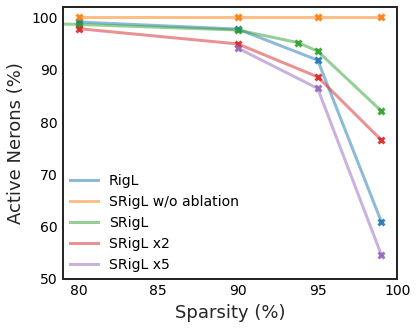

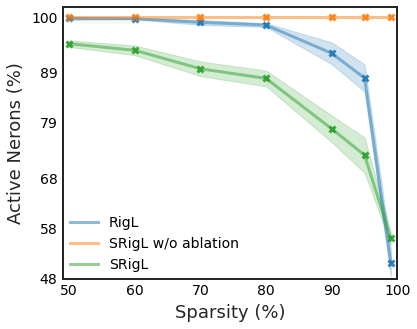

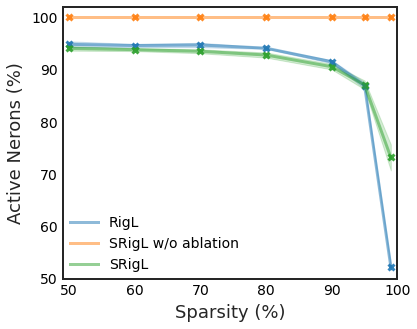

In [58]:
def plot_active_neurons_vs_sparsity(df, model_name="", ylim=[90,100], xlim=[49,100]):
    _TARGET_COL="_TOTAL_PERCENTAGE_ACTIVE_NEURONS"
    df=df.copy(deep=True)
    df = df.sort_values(by="rigl.dense_allocation")
    df["sparsity"] = (1-df["rigl.dense_allocation"])*100
    plot_dfs = []
    fig, ax = plt.subplots(figsize=_FIG_SIZE)

    for idx, (epoch, fan_in, dynamic_ablation) in enumerate(df.groupby(["epoch", "rigl.const_fan_in", "rigl.dynamic_ablation"], dropna=False).count().index.unique()): 
        df_slice = df.loc[(df["rigl.const_fan_in"] == fan_in) & (df["rigl.dynamic_ablation"] == dynamic_ablation) & (df["epoch"] == epoch)]    
        name, color = series_name_plot_mapper(fan_in, dynamic_ablation, df["epoch"].unique(), int(epoch))
        agg_results = get_confidence_bounds_df(df_slice, target_col=_TARGET_COL)
        # display(agg_results)
        if _PLOT_FUNCT=="scatter":
            ax.scatter(
                agg_results["sparsity"], agg_results["mean"], label=name, color=color, **_MEAN_MARKER
            )
            yerr= [a["upper_bound"]-a["mean"] for _,a in agg_results.iterrows()]
            ax.errorbar(agg_results["sparsity"], agg_results["mean"], yerr=yerr,fmt="none", color=color, elinewidth=0.5, capsize=3)
        else:
            ax.plot(
                agg_results["sparsity"], agg_results["mean"], label=name, color=color, marker=None, alpha=0.50
            )
            ax.scatter(
                agg_results["sparsity"], agg_results["mean"], label=None, color=color, **_MEAN_MARKER,
            )
            
            # ax.plot(
            #     agg_results["sparsity"], agg_results["mean"], label=name, color=color, **_MEAN_MARKER
            # )
            ax.fill_between(
                agg_results["sparsity"],
                agg_results["upper_bound"],
                agg_results["lower_bound"],
                color=color,
                alpha=0.20
            )
            # ax.scatter(
            #     df_slice["sparsity"], df_slice[_TARGET_COL], marker='o', color=color, alpha=0.5
            # )

    plt.xlabel('Sparsity (%)')
    plt.ylabel('Active Nerons (%)')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels,  loc="best")
    leg = ax.legend()
    leg.get_frame().set_linewidth(0.0)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    tick_spaces=5
    y_tick_eps = (max(ylim)-2 - min(ylim))/tick_spaces
    y_ticks = [int(min(ylim)+y_tick_eps*x) for x in range(tick_spaces+1)]
    ax.set_yticks(y_ticks)
    # ax.legend(bbox_to_anchor=.35,0.35)
    fig.savefig(f"../fig/{model_name}_perc_active.png", dpi=600, bbox_inches="tight")
    fig.savefig(f"../fig/{model_name}_perc_active.svg",format="svg", bbox_inches="tight")
    fig.savefig(f"../fig/{model_name}_perc_active.pdf",format="pdf", bbox_inches="tight")
    return fig

# sweep_id_ablation_exp = "a2uywunn"
# df.loc[df["sweep_id"]==sweep_id_ablation_exp]["rigl.dense_allocation"].unique()

# resnet18_const_fan_false_ids=df.loc[(df["sweep_id"]==sweep_id_ablation_exp) & (df["model"]=="resnet18")].index.to_list()
# wide_resnet22_const_fan_false_ids=df.loc[(df["sweep_id"]==sweep_id_ablation_exp) & (df["model"]=="wide_resnet22")].index.to_list()
# imagenet_ids = imagenet.loc[imagenet["rigl.dynamic_ablation"] == True].index
# fig = plot_active_neurons_vs_sparsity(imagenet.loc[imagenet_ids], "imagenet", ylim=[58, 100], xlim=[0.79, 1.0])
# fig = plot_active_neurons_vs_sparsity(df.loc[new_high_sparse_ids+resnet18_const_fan_false_ids], "resnet18", ylim=[50, 100])
# fig = plot_active_neurons_vs_sparsity(df.loc[wide_const_fan_ids+wide_resnet22_const_fan_false_ids], "wide_resnet22", ylim=[50, 100])

fig = plot_active_neurons_vs_sparsity(imagenet, "imagenet", ylim=[50, 102], xlim=[79, 100])
fig = plot_active_neurons_vs_sparsity(df.loc[resnet_ids], "resnet18", ylim=[48, 102])
fig = plot_active_neurons_vs_sparsity(df.loc[wide_res_ids], "wide_resnet22", ylim=[50, 102])


In [59]:
import torch
import torch.nn.functional as F
import torch.multiprocessing as mp
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel
from torch.utils.tensorboard import SummaryWriter
import pytorch_lightning as pl
import random
import dotenv
import omegaconf
import hydra
import logging
from typing import List

import wandb
from datetime import date
import dotenv
import os
import pathlib
from typing import Dict, Any
from copy import deepcopy

from rigl_torch.models import ModelFactory
from rigl_torch.rigl_scheduler import RigLScheduler
from rigl_torch.rigl_constant_fan import RigLConstFanScheduler
from rigl_torch.datasets import get_dataloaders
from rigl_torch.optim import (
    get_optimizer,
    get_lr_scheduler,
)
from rigl_torch.utils.checkpoint import Checkpoint
from rigl_torch.utils.rigl_utils import get_T_end, get_fan_in_after_ablation, get_conv_idx_from_flat_idx
from hydra import initialize, compose

_80_SPARSE_ID = '1ige8ylm'
_90_SPARSE_ID = '3p6dparl'



with initialize("../configs", version_base="1.2.0"):
    cfg = compose(
        "config.yaml",
        overrides=[
            "dataset=imagenet",
            "compute.distributed=False",
            "model=vit",
            # # "model=skinny_resnet18",
            # "rigl.dense_allocation=0.01",
            # "rigl.delta=2",
            # "rigl.grad_accumulation_n=1"
            ])
dotenv.load_dotenv("../.env")
os.environ["IMAGE_NET_PATH"]
print(cfg.model.name)


# checkpoint_dir=pathlib.Path("../artifacts/checkpoints/20230511_361mldkb")  # 80% sparse
# checkpoint_dir=pathlib.Path(f"../artifacts/checkpoints/20230605_{_80_SPARSE_ID}")  # 80% sparse
# checkpoint_dir=pathlib.Path("../artifacts/checkpoints/20230511_2sn0e1sy")  # 90% sparse
checkpoint_dir=pathlib.Path(f"../artifacts/checkpoints/20230601_{_90_SPARSE_ID}")  # 90% sparses
checkpoint = Checkpoint.load_best_checkpoint(checkpoint_dir=checkpoint_dir)

rank=0
# checkpoint=None
if checkpoint is not None:
    run_id = checkpoint.run_id
    optimizer_state = checkpoint.optimizer
    scheduler_state = checkpoint.scheduler
    pruner_state = checkpoint.pruner
    model_state = checkpoint.model
    cfg = checkpoint.cfg
else:
    run_id, optimizer_state, scheduler_state, pruner_state, model_state = (
        None,
        None,
        None,
        None,
        None,
    )

if "diet" not in cfg.rigl:
    with omegaconf.open_dict(cfg):
        cfg.rigl.diet = None
if "keep_first_layer_dense" not in cfg.rigl:
    with omegaconf.open_dict(cfg):
        cfg.rigl.keep_first_layer_dense = False
print(cfg.compute)
cfg.compute.distributed=False
    
pl.seed_everything(cfg.training.seed)
use_cuda = not cfg.compute.no_cuda and torch.cuda.is_available()
if not use_cuda:
    raise SystemError("GPU has stopped responding...waiting to die!")
    logger.warning(
        "Using CPU! Verify cfg.compute.no_cuda and "
        "torch.cuda.is_available() are properly set if this is unexpected"
    )

if cfg.compute.distributed and use_cuda:
    device = torch.device(f"cuda:{rank}")
else:
    print(f"loading to device rank: {rank}")
    device = torch.device(f"cuda:{rank}")
if not use_cuda:
    device = torch.device("cuda" if use_cuda else "cpu")
train_loader, test_loader = get_dataloaders(cfg)

model = ModelFactory.load_model(
    model=cfg.model.name, dataset=cfg.dataset.name, diet=cfg.rigl.diet
)
model.to(device)
if cfg.compute.distributed:
    model = DistributedDataParallel(model, device_ids=[rank])
if model_state is not None:
    try:
        model.load_state_dict(model_state)
    except RuntimeError:
        model_state = checkpoint.get_single_process_model_state_from_distributed_state()
        model.load_state_dict(model_state)
        
optimizer = get_optimizer(cfg, model, state_dict=optimizer_state)
scheduler = get_lr_scheduler(cfg, optimizer, state_dict=scheduler_state)
pruner = None
if cfg.rigl.dense_allocation is not None:
    if cfg.rigl.dense_allocation is not None:
        if cfg.model.name == "skinny_resnet18":
            dense_allocation = (
                cfg.rigl.dense_allocation * cfg.model.sparsity_scale_factor
            )
            print(
                f"Scaling {cfg.rigl.dense_allocation} by "
                f"{cfg.model.sparsity_scale_factor:.2f} for SkinnyResNet18 "
                f"New Dense Alloc == {dense_allocation:.6f}"
            )
        else:
            dense_allocation = cfg.rigl.dense_allocation
        T_end = get_T_end(cfg, [0 for _ in range(0,1251)])
        if cfg.rigl.const_fan_in:
            rigl_scheduler = RigLConstFanScheduler
        else:
            rigl_scheduler = RigLScheduler
        pruner = rigl_scheduler(
            model,
            optimizer,
            dense_allocation=cfg.rigl.dense_allocation,
            alpha=cfg.rigl.alpha,
            delta=cfg.rigl.delta,
            static_topo=cfg.rigl.static_topo,
            T_end=T_end,
            ignore_linear_layers=cfg.rigl.ignore_linear_layers,
            grad_accumulation_n=cfg.rigl.grad_accumulation_n,
            sparsity_distribution=cfg.rigl.sparsity_distribution,
            erk_power_scale=cfg.rigl.erk_power_scale,
            state_dict=pruner_state,
            filter_ablation_threshold=cfg.rigl.filter_ablation_threshold,
            static_ablation=cfg.rigl.static_ablation,
            dynamic_ablation=cfg.rigl.dynamic_ablation,
            min_salient_weights_per_neuron=cfg.rigl.min_salient_weights_per_neuron,  # noqa
            use_sparse_init=cfg.rigl.use_sparse_initialization,
            init_method_str=cfg.rigl.init_method_str,
            use_sparse_const_fan_in_for_ablation=cfg.rigl.use_sparse_const_fan_in_for_ablation,  # noqa
            initialize_grown_weights=cfg.rigl.initialize_grown_weights,
        )


vit


Global seed set to 42


{'no_cuda': False, 'cuda_kwargs': {'num_workers': '${ oc.decode:${oc.env:NUM_WORKERS} }', 'pin_memory': True}, 'distributed': True, 'world_size': 4, 'dist_backend': 'nccl'}
loading to device rank: 0


IndexError: The shape of the mask [768, 768] at index 0 does not match the shape of the indexed tensor [2304, 768] at index 0

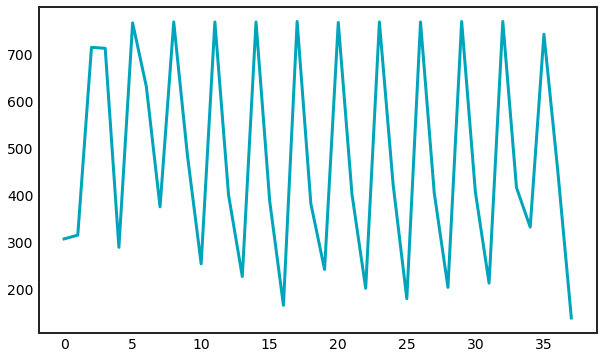

In [ ]:
from rigl_torch.utils.rigl_utils import get_fan_in_tensor
import pandas as pd
import matplotlib.pyplot as plt

mean=[]
std=[]
max=[]
min=[]
for i, m in enumerate(pruner.backward_masks):
    # print(f"Layer {i}")
    fan_in_t = get_fan_in_tensor(m.to("cpu"))
    fan_in_t = fan_in_t.type(torch.float32)
    max.append(fan_in_t.max().item())
    min.append(fan_in_t.min().item())
    mean.append(fan_in_t.mean(dtype=torch.float32).item())
    std.append(fan_in_t.std().item())
    
df_vit_neurons = pd.DataFrame(dict(
    mean=mean,
    std=std,
    max=max,
    min=min
))
plt.plot(df_vit_neurons.index, df_vit_neurons["max"])


In [ ]:
maaax = 0
for mi, ma, me in list(zip(min, max, mean)):
    print(mi, ma)
    m = ma/me
    if m > maaax:
        maaax=m
        
maaax


0.0 306.0
7.0 314.0
0.0 713.0
106.0 711.0
0.0 288.0
0.0 765.0
131.0 630.0
1.0 374.0
0.0 767.0
165.0 483.0
3.0 253.0
0.0 767.0
180.0 399.0
6.0 226.0
0.0 767.0
122.0 386.0
7.0 165.0
0.0 768.0
69.0 381.0
2.0 241.0
0.0 766.0
9.0 401.0
1.0 201.0
0.0 767.0
35.0 422.0
0.0 179.0
0.0 767.0
104.0 404.0
2.0 203.0
0.0 768.0
136.0 406.0
0.0 212.0
0.0 768.0
134.0 415.0
0.0 331.0
0.0 741.0
16.0 454.0
37.0 138.0


9.999982714682893

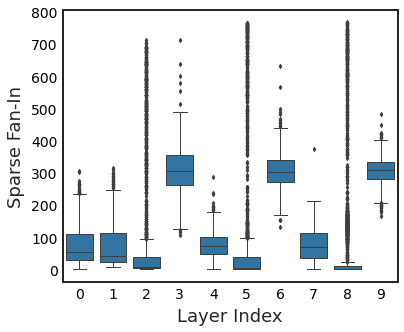

In [ ]:
y=[]
data = np.ndarray(shape=[len(pruner.backward_masks), ], dtype="object")
for i, m in enumerate(pruner.backward_masks):
    y.append(get_fan_in_tensor(m.to("cpu")).tolist())
fig,ax = plt.subplots(figsize=_FIG_SIZE)

sns.boxplot(data=y[:10], color=_COLORS[0], ax=ax, linewidth=1, fliersize=3)
ax.set_xlabel("Layer Index")
ax.set_ylabel("Sparse Fan-In")
fig.savefig(f"../fig/vit_rigl_fan_in.pdf", dpi=600, bbox_inches="tight")
# plt.boxplot(x=y:10])


KeyError: 'mean'

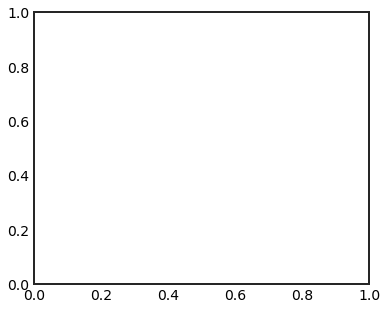

In [ ]:
def plot_vit_fan_in_connectivity(df, sparsity):
    fig,ax = plt.subplots(figsize=_FIG_SIZE)
    ax.plot(df.index, df["mean"])
    upper = df["mean"]+df["std"]
    lower = df["mean"]-df["std"]
    ax.plot(df.index, df["mean"])
    ax.fill_between(df.index, y1=df["min"], y2=df['max'])
    return fig

fig = plot_vit_fan_in_connectivity(df, 90)
